### Período 1

#### Importações

In [1]:
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "kaleido"])

0

In [2]:
import pandas as pd
import re
import emoji
import nltk
import numpy as np
import string
from nltk.corpus import stopwords
from urllib.parse import urlparse
import emoji

stop_words_pt = set(stopwords.words('portuguese'))
punctuation = set(string.punctuation)

nltk.download('punkt')      
nltk.download('punkt_tab') 

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import os

import networkx as nx

from networkx.algorithms import bipartite
from tqdm.auto import tqdm

from pyvis.network import Network
import matplotlib.colors as mcolors

import seaborn as sns
from bisect import bisect_right

import community.community_louvain as community_louvain # Requer: pip install python-louvain

import matplotlib

from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN

from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nasci\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nasci\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Pre-Processamento

In [3]:
df = pd.read_csv("dataset_zap_1.csv", low_memory=False)

df = df.dropna(subset=["text_content_anonymous"]).copy()
df = df.reset_index(drop=True)

In [4]:
# Garante que as stopwords do NLTK foram baixadas
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# 1. LISTAS DE BLOQUEIO
# ------------------------------------------------------------------------------

# Vandalismo e Travas
crash_keywords = [
    "trava", "crash", "binario", "destrava", "imune", "rajada", 
    "virus", "clonagem", "hacker", "phoenix", "revaneio", "alien_monster", 
    "࿗", "꙰", "‮", "bòsta nà", "caráê", 
    "auto entitula logan", "raimundo",
    "harbyngers", "fish", "crown", "sun"
]

# Spam Comercial
spam_keywords = [
    "limpar nome", "aumentar score", "cnpj", "crédito", "empréstimo", 
    "venda", "oferta", "desconto", "turismo", "excursão", "saída", 
    "ganhe", "oportunidade", "renda extra", "marketing", "consórcio",
    "delivery", "entregamos", "promoção",
    "popcorn", "clapper_board", "antenna_bars",
    "melhores canais", "sua tv", "venha adquirir", "adquirir sua",
    "internet ilimitada", "conexão ilimitada", "sem travamentos",
    "filmes", "séries", "canais", "iptv", "tv box", "hbo", "telecine", 
    "INTERNET ILIMITADA", "Internet Ilimitada", "vivo", "tim", "oi", "Venha",
    "kwaivideocom",
    "muita gente falando sobre notícia",
    "notícia deixa triste",
    "todos redor falando sobre notícia",
    "kwai"
]

# Stopwords Personalizadas
custom_stopwords = {
    "bom", "dia", "boa", "tarde", "noite", "olá", "oi", "ola", "tchau",
    "kk", "kkk", "kkkk", "kkkkk", "rs", "rsrs", "aff", "eita", "oxi", "oxe",
    "imagem", "figura", "sticker", "áudio", "audio", "vídeo", "video",
    "mensagem", "encaminhada", "apagou", "pra", "pro", "tá", "pq", "vc"
}

# Carregar NLTK + Unir com as suas
# ------------------------------------------------------------------------------
# 2. Carrega as stopwords padrão (de, para, o, a, um, uns...)
nltk_stopwords = set(stopwords.words('portuguese'))

#Faz a UNIÃO dos dois conjuntos. 
stop_words_total = nltk_stopwords.union(custom_stopwords)

# 4. FUNÇÕES AUXILIARES

def is_junk_message(text_lower):
    """
    Retorna True se a mensagem for considerada Lixo (Spam, Trava ou Vandalismo)
    """
    if len(text_lower) > 3000:
        return True
    if any(term in text_lower for term in crash_keywords):
        return True
    if any(term in text_lower for term in spam_keywords):
        return True
    return False

def simplify_urls(text):
    """
    Substitui URLs completas apenas pelo domínio principal.
    """
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    
    def extract_domain(match):
        url = match.group(0)
        if not url.startswith('http'):
            url = 'http://' + url
        try:
            parsed = urlparse(url)
            domain = parsed.netloc
            return domain.replace('www.', '')
        except:
            return url 

    return url_pattern.sub(extract_domain, text)

In [5]:
# FUNÇÃO DE PRÉ-PROCESSAMENTO
# ------------------------------------------------------------------------------
def preprocess_text_final(text):
    # Check básico de tipo
    if not isinstance(text, str):
        return []
    
    # Normaliza para minúsculo
    text_lower = text.lower()

    # PASSO 1:função auxiliar para detectar LIXO rapidamente
    if is_junk_message(text_lower):
        return []

    # PASSO 2: Tratamento Inteligente de URLs
    # Em vez de remover, simplificamos para o domínio. 
    text = simplify_urls(text) 
    
    # PASSO 3: Limpeza de Emojis e Tokenização
    text = emoji.demojize(text) 
    
    # Remove pontuação antes de tokenizar para evitar tokens sujos
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    tokens = nltk.word_tokenize(text.lower())
    
    tokens_clean = []
    for token in tokens:
        # Remove se for stopword
        if token in stop_words_total: continue
        
        # Remove se for pontuação (redundância de segurança)
        if token in string.punctuation: continue
        
        # Remove tokens muito curtos (ex: "h", "1")
        if len(token) < 2: continue
        
        # Remove tokens que sobraram da demojização se não forem úteis
        if token.startswith(":") and token.endswith(":"):
             pass

        tokens_clean.append(token)
    
    return tokens_clean

print(">>> Iniciando pré-processamento...")
tqdm.pandas()

# Aplica a função
df['tokens_preprocessed'] = df['text_content_anonymous'].progress_apply(preprocess_text_final)

# PASSO: Remover mensagens que resultaram em menos de 2 tokens válidos
print(">>> Filtrando mensagens curtas (< 2 tokens úteis)...")

# Cria uma máscara booleana
mask_valid = df['tokens_preprocessed'].map(len) >= 2 

# Aplica o filtro
df_limpo = df[mask_valid].copy()

# Junta a lista ['ola', 'mundo'] na string "ola mundo" para o TF-IDF
df_limpo['clean_text'] = df_limpo['tokens_preprocessed'].apply(lambda x: " ".join(x))

# Resetar índice (alinhar com a matriz esparsa do TF-IDF depois)
df_limpo = df_limpo.reset_index(drop=True)

# Atualiza variáveis globais
df = df_limpo
texts = df["clean_text"].astype(str).tolist()
times = df["date_message"].tolist()
N = len(df)

qtde_removida = len(df) - len(df_limpo)
print(f"Linhas removidas (Spam / Lixo / Curtas): {qtde_removida}")
print(f"Tamanho FINAL para análise: {len(df_limpo)}")


# ==============================================================================
# 5. VERIFICAÇÃO E SALVAMENTO
# ==============================================================================
print("\n>>> Amostra do Resultado Final:")
print(df_limpo[['text_content_anonymous', 'clean_text']].head(5))

print("\n>>> Salvando arquivo...")
df_limpo.to_csv("dataset_zap_1_preprocessado.csv", index=False, encoding='utf-8-sig')
print("Arquivo 'dataset_zap_1_preprocessado.csv' salvo com sucesso!")

# Atualizar a variável df principal para a próxima etapa
df = df_limpo

>>> Iniciando pré-processamento...


  0%|          | 0/260153 [00:00<?, ?it/s]

>>> Filtrando mensagens curtas (< 2 tokens úteis)...
Linhas removidas (Spam / Lixo / Curtas): 0
Tamanho FINAL para análise: 122817

>>> Amostra do Resultado Final:
                              text_content_anonymous  \
0  Urgente: Pesquisa Brasmarket aponta vitória de...   
1  https://youtu.be/9St9wUrpU_c\n\n🇧🇷🇧🇷🇧🇷🌿🌿🌿🇧🇷🇧🇷🇧...   
2  👆 *BIOMETRIA NAS URNAS!*\n\n*O presidente do T...   
3  👆 *BIOMETRIA NAS URNAS!*\n\n*O presidente do T...   
4  LULA ontem, dia 16 de agosto, no lançamento de...   

                                          clean_text  
0  urgente pesquisa brasmarket aponta vitória bol...  
1  youtube brazilbrazilbrazilherbherbherbbrazilbr...  
2  backhandindexpointingup biometria urnas presid...  
3  backhandindexpointingup biometria urnas presid...  
4  lula ontem 16 agosto lançamento campanha bêbad...  

>>> Salvando arquivo...
Arquivo 'dataset_zap_1_preprocessado.csv' salvo com sucesso!


In [6]:
print(">>> Preparando vetores para o Motor de Detecção...")

# 1. CONVERSÃO DE DATA
if not pd.api.types.is_datetime64_any_dtype(df['date_message']):
    print("Convertendo coluna de datas para datetime...")
    df['date_message'] = pd.to_datetime(df['date_message'], errors='coerce')

# Remove linhas onde a data falhou (NaT)
df = df.dropna(subset=['date_message']).copy()

# 2. ORDENAÇÃO TEMPORAL (OBRIGATÓRIO PARA JANELA DESLIZANTE)
# A lógica de "Rapid Spread" exige que os dados estejam em ordem cronológica
# para que o algoritmo pare de procurar assim que passar de 60s.
print("Ordenando dataset por data...")
df = df.sort_values(by='date_message', ascending=True).reset_index(drop=True)

# 3. CRIAÇÃO DAS LISTAS FINAIS
texts = df["clean_text"].astype(str).tolist()
times = df["date_message"].tolist()
users = df["id_member_anonymous"].tolist() 
groups = df["id_group_anonymous"].tolist() 
N = len(df)

print(f"Total de mensagens: {N}")
print(f"Intervalo temporal: de {df['date_message'].min()} até {df['date_message'].max()}")

>>> Preparando vetores para o Motor de Detecção...
Convertendo coluna de datas para datetime...
Ordenando dataset por data...
Total de mensagens: 122817
Intervalo temporal: de 2022-08-17 19:35:16 até 2022-10-29 23:59:08


In [7]:
# ==============================================================================
# ATUALIZAÇÃO DE LISTAS E VETORIZAÇÃO (TF-IDF)
# ==============================================================================
import scipy.sparse
from sklearn.feature_extraction.text import TfidfVectorizer

print(">>> [BLOCO 1] Atualizando listas e gerando Matriz TF-IDF...")

# 1.VARIÁVEIS
# listas sincronizadas pelo índice: Quem, O quê, Quando.
texts = df["clean_text"].astype(str).tolist()
times = df["date_message"].tolist()
users = df["id_member_anonymous"].tolist() 
groups = df["id_group_anonymous"].tolist() 
N = len(df)

print(f"Dados atualizados: {N} mensagens para analisar.")

# 2. CONFIGURAR O VECTORIZER
# min_df=2: Remove palavras que aparecem em apenas 1 mensagem (erros de digitação/ruído único)
# dtype=np.float32: Reduz o consumo de memória RAM pela metade
vectorizer = TfidfVectorizer(min_df=2, dtype=np.float32) 

# 3. TRANSFORMAR TEXTO EM NÚMEROS
print("Vetorizando...")
X = vectorizer.fit_transform(texts)

# 4. OTIMIZAÇÃO (CSR)
X = X.tocsr()

print(f"Matriz TF-IDF gerada com sucesso: {X.shape}")
print(f"Vocabulário aprendido: {X.shape[1]} palavras únicas.")
print("(Linhas = Mensagens, Colunas = Palavras)")

>>> [BLOCO 1] Atualizando listas e gerando Matriz TF-IDF...
Dados atualizados: 122817 mensagens para analisar.
Vetorizando...
Matriz TF-IDF gerada com sucesso: (122817, 43051)
Vocabulário aprendido: 43051 palavras únicas.
(Linhas = Mensagens, Colunas = Palavras)


>>> [SONDAGEM] Coletando dados (Janela 60s | Similaridade > 0.0)...


Sondando:   0%|          | 0/24564 [00:00<?, ?it/s]

>>> Dados coletados: 26712 pares.


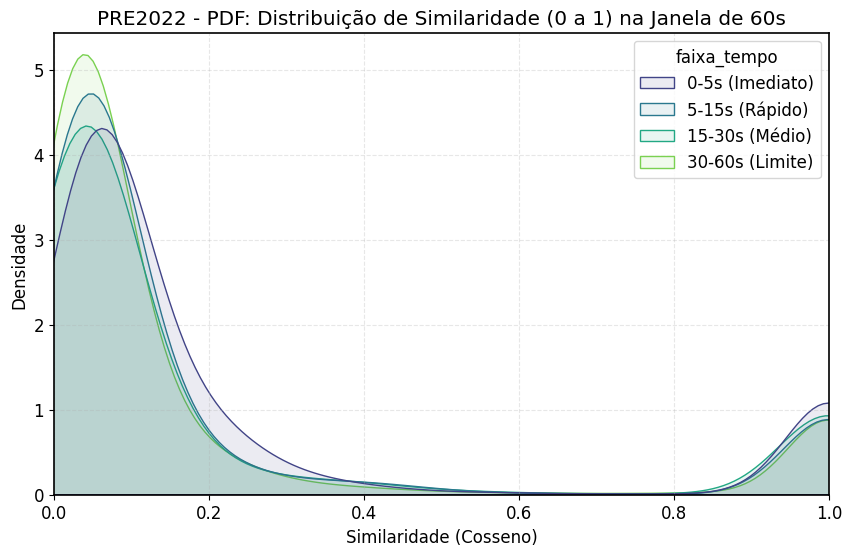

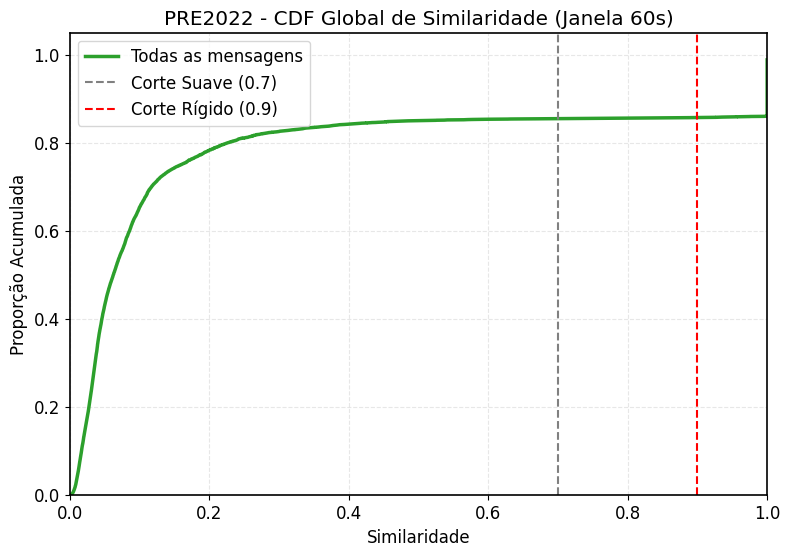

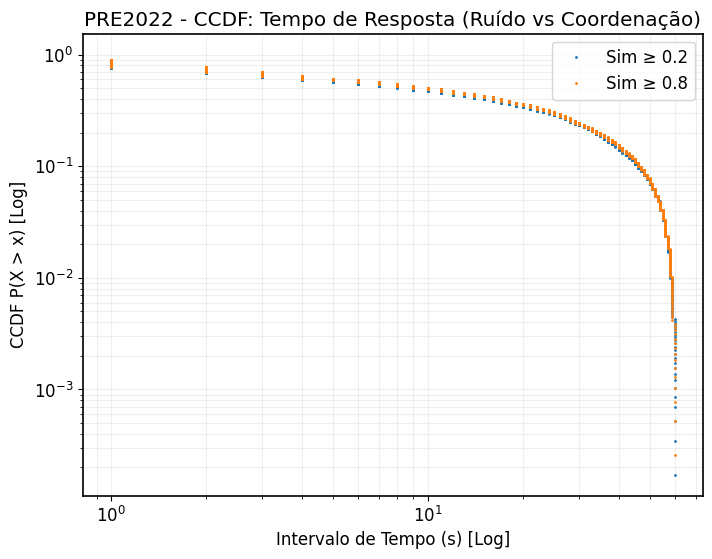

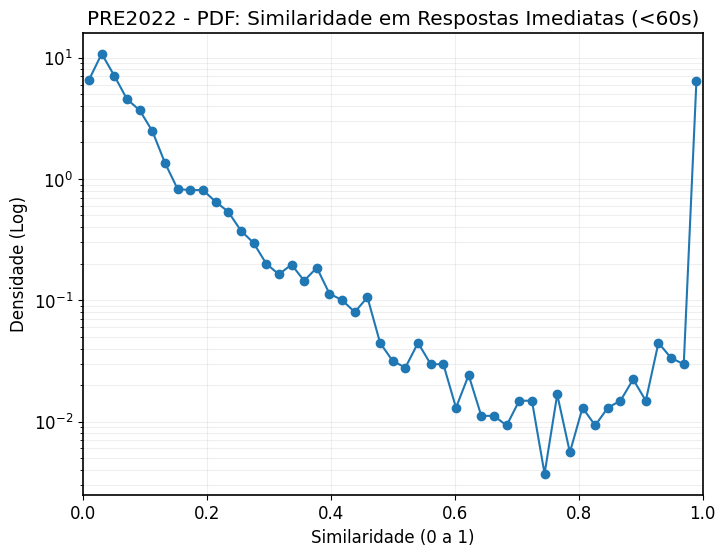

In [8]:
# SONDAGEM
print(">>> [SONDAGEM] Coletando dados (Janela 60s | Similaridade > 0.0)...")

def coletar_dados_sondagem_60s(max_window=60, min_sim=0.0):
    amostras = []
    time_window = pd.Timedelta(seconds=max_window)
    
    step = 1 if N < 50000 else 5 
    
    for i in tqdm(range(0, N - 1, step), desc="Sondando"):
        t_i = times[i]
        t_limit = t_i + time_window
        
        # Busca Binária para achar o fim da janela de 60s
        end_idx = bisect_right(times, t_limit, lo=i+1)
        if end_idx <= i + 1: continue
            
        # Bloco de comparação
        block = X[i+1 : end_idx]
        vec_i = X[i]
        
        # Cálculo vetorial
        sims = block.dot(vec_i.T).toarray().flatten()
        
        # Filtro (pegando tudo > 0 para ver a curva completa)
        valid_indices = np.where(sims > min_sim)[0]
        
        if len(valid_indices) > 0:
            global_indices = (i + 1) + valid_indices
            valid_sims = sims[valid_indices]
            for g_idx, s_val in zip(global_indices, valid_sims):
                dt = (times[g_idx] - t_i).total_seconds()
                amostras.append({"delta_t": dt, "similarity": float(s_val)})

    return pd.DataFrame(amostras)

# Rodar a coleta
df_sondagem = coletar_dados_sondagem_60s()

# ==============================================================================
# 2. PLOTAGEM BÁSICA (PDF & CDF)
# ==============================================================================
if not df_sondagem.empty:
    print(f">>> Dados coletados: {len(df_sondagem)} pares.")
    
    plt.rcParams.update({'font.size': 12, 'axes.linewidth': 1.2, 'grid.alpha': 0.3})

    # --- GRÁFICO 1: PDF (Densidade) ---
    plt.figure(figsize=(10, 6))
    
    # Faixas de tempo ajustadas para janela de 60s
    bins = [0, 5, 15, 30, 60]
    labels = ['0-5s (Imediato)', '5-15s (Rápido)', '15-30s (Médio)', '30-60s (Limite)']
    
    df_sondagem['faixa_tempo'] = pd.cut(df_sondagem['delta_t'], bins=bins, labels=labels)
    
    sns.kdeplot(
        data=df_sondagem, 
        x='similarity', 
        hue='faixa_tempo', 
        fill=True, 
        common_norm=False, 
        palette="viridis",
        alpha=0.1
    )
    
    plt.xlim(0.0, 1.0) 
    plt.title('PRE2022 - PDF: Distribuição de Similaridade (0 a 1) na Janela de 60s')
    plt.xlabel('Similaridade (Cosseno)')
    plt.ylabel('Densidade')
    plt.grid(True, linestyle='--')
    plt.savefig("Grafico_PDF_0_a_1.png", dpi=300)
    plt.show()

    # --- GRÁFICO 2: CDF (Acumulação) ---
    plt.figure(figsize=(9, 6))
    
    # Ordenar por similaridade para ver a curva de crescimento
    sorted_sims = np.sort(df_sondagem['similarity'])
    yvals = np.arange(1, len(sorted_sims) + 1) / len(sorted_sims)
    
    plt.plot(sorted_sims, yvals, color='#2ca02c', linewidth=2.5, label='Todas as mensagens')
    
    # Marcações visuais
    plt.axvline(0.7, color='gray', linestyle='--', label='Corte Suave (0.7)')
    plt.axvline(0.9, color='red', linestyle='--', label='Corte Rígido (0.9)')
    
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.05)
    plt.xlabel("Similaridade")
    plt.ylabel("Proporção Acumulada")
    plt.title("PRE2022 - CDF Global de Similaridade (Janela 60s)")
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.savefig("Grafico_CDF_Similaridade.png", dpi=300)
    plt.show()


    # --- GRÁFICO 3: CCDF Log-Log (Intervalos Temporais) ---
    plt.figure(figsize=(8, 6))
    
    # Compara similaridade baixa (ruído) vs alta (coordenação)
    for limiar in [0.2, 0.8]: 
        subset = df_sondagem[df_sondagem['similarity'] >= limiar]
        if not subset.empty:
            data_sorted = np.sort(subset['delta_t'])
            yvals = 1.0 - (np.arange(1, len(data_sorted) + 1) / len(data_sorted))
            plt.loglog(data_sorted, yvals, marker='.', linestyle='none', 
                       markersize=2, label=f'Sim ≥ {limiar}')
    
    plt.xlabel("Intervalo de Tempo (s) [Log]")
    plt.ylabel("CCDF P(X > x) [Log]")
    plt.title("PRE2022 - CCDF: Tempo de Resposta (Ruído vs Coordenação)")
    plt.legend()
    plt.grid(True, which="both", alpha=0.2)
    plt.savefig("Grafico_CCDF_Comparativo.png", dpi=300)
    plt.show()

    # --- GRÁFICO 4: PDF Semi-Log (Similaridade em Delta T curto) ---
    plt.figure(figsize=(8, 6))
    
    # Foco no "Immediate Spread" (<10s)
    df_short = df_sondagem[df_sondagem['delta_t'] <= 60]
    
    if not df_short.empty:
        # Histograma cobrindo 0 a 1
        hist, edges = np.histogram(df_short['similarity'], bins=np.linspace(0, 1, 50), density=True)
        centers = (edges[:-1] + edges[1:]) / 2
        
        plt.semilogy(centers, hist, marker='o', linestyle='-', color='#1f77b4')
        
        plt.xlabel("Similaridade (0 a 1)")
        plt.ylabel("Densidade (Log)")
        plt.title("PRE2022 - PDF: Similaridade em Respostas Imediatas (<60s)")
        plt.xlim(0, 1)
        plt.grid(True, which="both", alpha=0.2)
        plt.savefig("Grafico_PDF_SemiLog_FullRange.png", dpi=300)
        plt.show()

else:
    print("Nenhum dado encontrado.")

### Interpretação

#### PDF

- Forte pico em similaridades baixas (≈ 0–0.2) -> Ruído / conversa normal de baixa similaridade

- Uma cauda longa até valores intermediários.

- Um novo crescimento abrupto próximo de 1.0: Coordenação explícita -> alta similaridade (quase cópia/paráfrase). O pico próximo de 1.0 não é natural em linguagem espontânea: Indica repostagem, templates, encaminhamentos ou mensagens fortemente padronizadas.


Quanto menor o Δt, maior a densidade no extremo alto (≈0.9–1.0). A janela 0–5s é a que mais concentra mensagens altamente similares. Forte indício de que a Coordenação semântica forte ocorre quase instantaneamente. À medida que o tempo passa, o conteúdo diverge mesmo quando há resposta.

Mesmo representando uma minoria dos pares, mensagens altamente similares concentram-se em janelas temporais curtas, caracterizando eventos de coordenação.

Os resultados revelam uma clara separação entre interações orgânicas e eventos de coordenação. Enquanto a maior parte das mensagens apresenta baixa similaridade textual, observa-se um subconjunto pequeno porém consistente de mensagens altamente similares, concentradas em janelas temporais extremamente curtas. Esse padrão é compatível com comportamentos coordenados, caracterizados por sincronização temporal e reutilização textual, e não pode ser explicado apenas por dinâmica conversacional espontânea.

Coletando offset +1:   0%|          | 0/122816 [00:00<?, ?it/s]

Coletando offset +2:   0%|          | 0/122815 [00:00<?, ?it/s]

Coletando offset +3:   0%|          | 0/122814 [00:00<?, ?it/s]

Coletando offset +4:   0%|          | 0/122813 [00:00<?, ?it/s]

Coletando offset +5:   0%|          | 0/122812 [00:00<?, ?it/s]

Coletando offset +10:   0%|          | 0/122807 [00:00<?, ?it/s]

Pares coletados: 736877


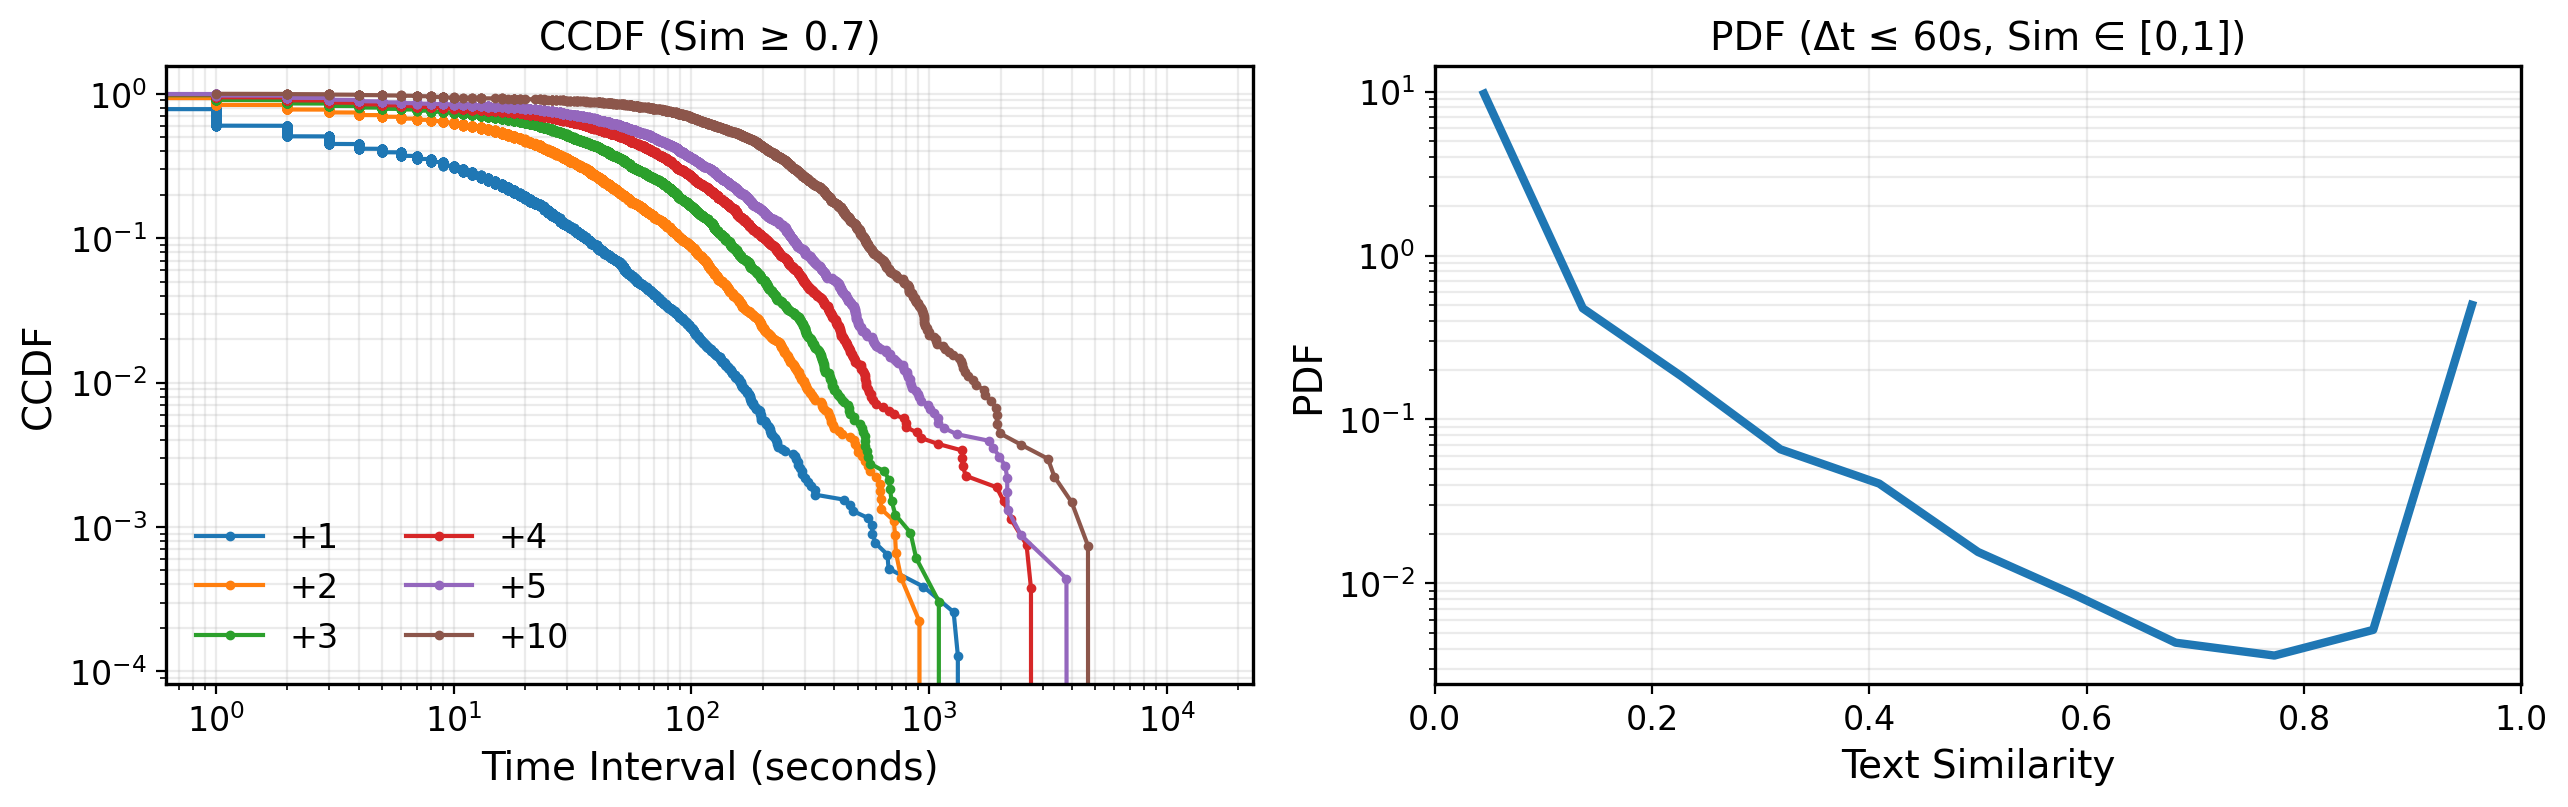

In [9]:
# Parâmetros
TAU_SIM_COLLECT = 0.0     # coleta tudo
TAU_SIM_CCDF    = 0.7     # CCDF exige sim >= 0.7
TAU_TIME_PDF    = 60      # PDF: pares com Δt <= 60s
OFFSETS = [1, 2, 3, 4, 5, 10]

# ------------------------------------------------------------------------------
# 1) Coletar pares i vs i+k
# ------------------------------------------------------------------------------
def coletar_sequential_pairs(times, X, offsets, tau_sim=0.0):
    rows = []
    N = len(times)

    for k in offsets:
        for i in tqdm(range(0, N - k), desc=f"Coletando offset +{k}"):
            j = i + k

            dt = (times[j] - times[i]).total_seconds()
            sim = float(X[i].dot(X[j].T).toarray()[0, 0])

            if sim >= tau_sim:
                rows.append({"offset": k, "delta_t": dt, "similarity": sim})

    return pd.DataFrame(rows)

df_seq = coletar_sequential_pairs(times, X, OFFSETS, tau_sim=TAU_SIM_COLLECT)
print("Pares coletados:", len(df_seq))

# ------------------------------------------------------------------------------
# 2) Plot: (A) CCDF log-log de delta_t por offset +k (sim >= 0.7)
#          (B) PDF de similaridade (Δt <= 60s, sim 0..1)
# ------------------------------------------------------------------------------
def plot_paper_style(df_seq, out_png="Figura_PaperStyle_CCDF_PDF.png"):
    plt.rcParams.update({
        "font.size": 12,
        "axes.linewidth": 1.2,
        "axes.labelsize": 14,
        "axes.titlesize": 14,
        "legend.fontsize": 12,
    })

    fig, axs = plt.subplots(1, 2, figsize=(13, 4.2), dpi=200)

    # -------------------------
    # (A) CCDF log-log (delta_t) com sim >= 0.7
    # -------------------------
    ax = axs[0]
    df_ccdf = df_seq[df_seq["similarity"] >= TAU_SIM_CCDF]

    for k in sorted(df_seq["offset"].unique()):
        sub = df_ccdf[df_ccdf["offset"] == k]
        if sub.empty:
            continue

        x = np.sort(sub["delta_t"].values)
        y = 1.0 - (np.arange(1, len(x) + 1) / len(x))

        ax.loglog(x, y, marker="o", markersize=2.5, linewidth=1.5, label=f"+{k}")

    ax.set_xlabel("Time Interval (seconds)")
    ax.set_ylabel("CCDF")
    ax.set_title(f"CCDF (Sim ≥ {TAU_SIM_CCDF})")
    ax.grid(True, which="both", alpha=0.25)
    ax.legend(ncol=2, frameon=False)

    # -----------------------------------------
    # (B) PDF de similaridade (Δt <= 60s) com sim 0..1
    # -----------------------------------------
    ax = axs[1]
    sub = df_seq[df_seq["delta_t"] <= TAU_TIME_PDF]

    if not sub.empty:
        sims = sub["similarity"].values  # já está 0..1
        bins = np.linspace(0, 1, 12)
        hist, edges = np.histogram(sims, bins=bins, density=True)
        centers = (edges[:-1] + edges[1:]) / 2

        ax.plot(centers, hist, linewidth=3)

        ax.set_yscale("log")
        ax.set_xlabel("Text Similarity")
        ax.set_ylabel("PDF")
        ax.set_title(f"PDF (Δt ≤ {TAU_TIME_PDF}s, Sim ∈ [0,1])")
        ax.grid(True, which="both", alpha=0.25)
    else:
        ax.text(0.5, 0.5, f"Sem pares com Δt ≤ {TAU_TIME_PDF}s",
                ha="center", va="center")
        ax.set_axis_off()

    plt.tight_layout()
    plt.savefig(out_png, bbox_inches="tight")
    plt.show()

plot_paper_style(df_seq, out_png="Figura_PaperStyle_CCDF_PDF.png")


### Interpretação


- Cada curva (+1, +2, +3, +4, +5, +10) representa a comparação entre uma mensagem e a k-ésima mensagem seguinte na sequência temporal.

- O eixo X (log) é o intervalo de tempo entre as mensagens e o eixo Y (log) é a CCDF: 𝑃(Δ𝑡 > 𝑥) Ou seja: qual a probabilidade de o intervalo entre mensagens ainda ser maior que x segundos.

Há uma queda acentuada da CCDF nas primeiras dezenas a centenas de segundos, indicando que uma parcela significativa das mensagens altamente similares é publicada em intervalos de tempo muito curtos. Além disso, o formato qualitativamente semelhante das curvas para diferentes offsets sugere que o padrão temporal é estável e independe da posição relativa das mensagens na sequência, caracterizando um processo recorrente de propagação sincronizada, consistente com comportamentos coordenados e distinto de dinâmicas orgânicas de difusão ao longo do tempo.

O painel à direita apresenta a distribuição de probabilidade (PDF) da similaridade textual para pares de mensagens publicados com Δ𝑡 segundos, considerando todo o intervalo 0,1. Nota-se um pico pronunciado de densidade para valores de similaridade próximos de 1, evidenciando a presença de replicação textual quase exata, típica de comportamentos de copiar--colar ou de reenvios com modificações mínimas. A ocorrência desse pico é uma consequência direta da restrição temporal curta, que isola respostas imediatas, e não um artefato do método de vetorização.

Ao mesmo tempo, a distribuição apresenta massa não desprezível em valores de similaridade ligeiramente inferiores a 1, indicando a existência de variações textuais leves, por conta das mensagens de conversas normais entre os integrantes dos grupos.


In [10]:
print(">>> DIAGNÓSTICO DO PICO DE SIMILARIDADE")

# 1. Verificar se a sondagem existe
if 'df_sondagem' not in locals() or df_sondagem.empty:
    print("ERRO: Rode a etapa de Sondagem anterior primeiro!")
else:
    # 2. Filtrar apenas o pico
    df_pico = df_sondagem[df_sondagem['similarity'] > 0.99].copy()
    
    if df_pico.empty:
        print("Curioso... Não há mensagens com similaridade > 0.99 na sondagem.")
        print("Tente baixar o filtro para > 0.95.")
    else:
        # 3. Recuperar o texto original
        print(f"Analisando {len(df_pico)} pares idênticos encontrados...")

        amostra_pico = df_pico.head(100) 
        
        textos_encontrados = []
        
        # Contar repetições no dataset LIMPO diretamente
        # Se tem pico em 1.0, tem texto duplicado no dataframe.
    
        top_duplicatas = df['clean_text'].value_counts().head(20)
        
        print("\nTOP 20 MENSAGENS REPETIDAS NO DATASET LIMPO:")
        print("(Se isso aqui for Spam, o filtro falhou. Se for 'Bom dia', é ruído. Se for política, é ouro.)\n")
        
        for texto, qtd in top_duplicatas.items():
            print(f"[{qtd}x] {texto[:100]}...") # Mostra os primeiros 100 caracteres
            print("-" * 50)

        # Diagnóstico de Tamanho
        print("\nEstatísticas de Tamanho das Duplicatas:")
        top_duplicatas_df = top_duplicatas.reset_index()
        top_duplicatas_df.columns = ['texto', 'contagem']
        top_duplicatas_df['tamanho'] = top_duplicatas_df['texto'].str.len()
        
        curtas = len(top_duplicatas_df[top_duplicatas_df['tamanho'] < 10])
        longas = len(top_duplicatas_df[top_duplicatas_df['tamanho'] > 50])
        
        print(f"Das Top 20 repetidas:")
        print(f"- Curtas (<10 chars, ex: 'ok', 'bom dia'): {curtas}")
        print(f"- Longas (>50 chars, ex: virais/textões): {longas}")

        if curtas > longas:
            print("\n>>> CONCLUSÃO: O pico é causado por MENSAGENS CURTAS (Ruído).")
        else:
            print("\n>>> CONCLUSÃO: O pico é causado por CONTEÚDO VIRAL REAL.")

>>> DIAGNÓSTICO DO PICO DE SIMILARIDADE
Analisando 3746 pares idênticos encontrados...

TOP 20 MENSAGENS REPETIDAS NO DATASET LIMPO:
(Se isso aqui for Spam, o filtro falhou. Se for 'Bom dia', é ruído. Se for política, é ouro.)

[478x] acesse link entrar grupo whatsapp chatwhatsappcom...
--------------------------------------------------
[306x] pesquisa eleitoral presidente república 2022 vote rightarrowcurvingdown financaswebclub...
--------------------------------------------------
[254x] toque ver backhandindexpointingdownmediumlightskintonebackhandindexpointingdownmediumlightskintoneba...
--------------------------------------------------
[210x] lula bolsonaro ganhando descubra verdade vote rightarrowcurvingdown eleicoes2022info...
--------------------------------------------------
[184x] pesquisa eleitoral presidente república 2022 vote rightarrowcurvingdown creditoparacartaocom...
--------------------------------------------------
[103x] popcorn ᴛᴇɴʜᴀ ᴏs ᴍᴇʟʜᴏʀᴇs ᴄᴀɴᴀɪs ғɪʟᴍᴇs sᴇ‌

### Construção da rede

In [11]:
# Parâmetros definidos pela análise dos gráficos:
TIME_WINDOW = 60        # 60 segundos (Kansaon et al.)
MIN_SIMILARITY = 0.70   # Similaridade >= 0.7 (Pacheco)
MIN_WEIGHT = 2          # Mínimo de interações para considerar coordenação (Filtro de Ruído)
                        # Nota: Kansaon usou 5

print(f">>> Iniciando construção da rede de coordenação...")
print(f"Janela: {TIME_WINDOW}s | Similaridade > {MIN_SIMILARITY} | Peso Mínimo: {MIN_WEIGHT}")

# Estruturas para guardar as arestas
edges = {} # Dicionário {(user_a, user_b): peso}
window_td = pd.Timedelta(seconds=TIME_WINDOW)

for i in tqdm(range(N), desc="Processando janelas"):
    
    # 1. Definir limites da janela deslizante para a mensagem i
    t_start = times[i]
    t_end = t_start + window_td
    
    # 2. Busca Binária (Otimização Extrema)
    # Encontra onde termina a janela de 60s na lista de tempos ordenada
    slice_end = bisect_right(times, t_end, lo=i+1)
    
    # Se não tem ninguém na janela, pula para a próxima mensagem
    if slice_end <= i + 1:
        continue
        
    # 3. Pegar o bloco de mensagens vizinhas (candidatos a coordenação)
    current_vec = X[i]
    candidate_block = X[i+1 : slice_end]
    
    # 4. Cálculo de Similaridade em Lote (Matricial)
    # Calcula o cosseno de [i] contra todos os vizinhos da janela de uma vez só
    similarities = candidate_block.dot(current_vec.T).toarray().flatten()
    
    # 5. Filtragem e Criação de Arestas
    # Pega apenas os índices onde a similaridade superou o corte de 0.7
    match_indices = np.where(similarities >= MIN_SIMILARITY)[0]
    
    if len(match_indices) > 0:
        user_i = users[i] # Quem mandou a mensagem original
        
        # Ajustar índices locais para globais
        global_indices = (i + 1) + match_indices
        
        for g_idx in global_indices:
            user_j = users[g_idx] # Quem mandou a mensagem coordenada
            
            # Regra: Não criar aresta consigo mesmo (self-loop)
            if user_i == user_j:
                continue
            
            # Ordenar IDs para garantir que a aresta (A, B) seja igual a (B, A)
            # Isso cria uma rede "Não Direcionada" (Undirected), padrão para coordenação
            u1, u2 = sorted((str(user_i), str(user_j)))
            key = (u1, u2)
            
            # Contabilizar peso (força da coordenação)
            edges[key] = edges.get(key, 0) + 1

# ==============================================================================
# 4. EXPORTAÇÃO DA REDE
# ==============================================================================
print(f"\n>>> Processamento concluído!")
print(f"Total de pares brutos encontrados: {len(edges)}")

# Criar DataFrame de arestas
df_edges = pd.DataFrame(
    [(u1, u2, w) for (u1, u2), w in edges.items()],
    columns=['Source', 'Target', 'Weight']
)

# Filtro de Peso
# Removemos pares que coincidiram apenas 1 vez (pode ser acaso) se MIN_WEIGHT > 1
df_edges_filtered = df_edges[df_edges['Weight'] >= MIN_WEIGHT].copy()

print(f"Arestas finais após filtro de peso (Weight >= {MIN_WEIGHT}): {len(df_edges_filtered)}")

# Salvar arquivo pronto para Gephi / NetworkX
filename_out = "rede_coordenacao_final_07_60s.csv"
df_edges_filtered.to_csv(filename_out, index=False)
print(f"Arquivo de rede salvo com sucesso: {filename_out}")

# Estatísticas rápidas da rede gerada
n_nodes = pd.concat([df_edges_filtered['Source'], df_edges_filtered['Target']]).nunique()
print(f"Número de Usuários Coordenados (Nós): {n_nodes}")

>>> Iniciando construção da rede de coordenação...
Janela: 60s | Similaridade > 0.7 | Peso Mínimo: 2


Processando janelas:   0%|          | 0/122817 [00:00<?, ?it/s]


>>> Processamento concluído!
Total de pares brutos encontrados: 740
Arestas finais após filtro de peso (Weight >= 2): 129
Arquivo de rede salvo com sucesso: rede_coordenacao_final_07_60s.csv
Número de Usuários Coordenados (Nós): 170


In [12]:
# ------------------------------------------------------------
# 1) Configuração Inicial da Rede
# ------------------------------------------------------------
net = Network(
    height="800px",
    width="100%",
    bgcolor="#ffffff",
    font_color="#222",
    notebook=False,
    directed=False
)

# 2) Ajustes de física (Opcional)
net.barnes_hut(gravity=-8000, central_gravity=0.3, spring_length=120, spring_strength=0.02, damping=0.25)
net.toggle_physics(True)
net.show_buttons(filter_=["physics"]) 

# ------------------------------------------------------------
# 3) Loop para Adicionar Nós e Arestas
# ------------------------------------------------------------

# Verifica se o dataframe existe antes de tentar iterar
if 'df_edges_filtered' in locals():
    print("Iniciando a construção da rede...")
    
    for index, row in df_edges_filtered.iterrows():
        
        # Ajuste os nomes das colunas conforme seu CSV ('source', 'target', 'Weight')
        u = row['Source'] 
        v = row['Target']
        w = int(row['Weight'])

        # --- VERIFICAÇÃO DE NÓS (CORREÇÃO DO KEYERROR) ---
        
        # Verifica o nó de origem (u)
        try:
            net.get_node(u)
        except KeyError:
            # Se der erro, cria o nó. O title é o tooltip (aparece ao passar o mouse)
            net.add_node(u, label=str(u), title=f"Usuário: {u}")

        # Verifica o nó de destino (v)
        try:
            net.get_node(v)
        except KeyError:
            net.add_node(v, label=str(v), title=f"Usuário: {v}")

        # --- FIM DA VERIFICAÇÃO ---

        # Adiciona a aresta
        net.add_edge(u, v, value=w, title=f"Peso: {w}")

    print(f"Rede criada com sucesso: {len(net.nodes)} nós e {len(net.edges)} arestas.")

else:
    print("ERRO: O DataFrame 'df_edges_filtered' não foi encontrado. Carregue seus dados antes.")

# ------------------------------------------------------------
# 4) Salvar o arquivo HTML
# ------------------------------------------------------------
filename_html = "rede_coordenacao_interativa.html"

try:
    # Gera o HTML como string
    html_content = net.generate_html()
    
    # Salva forçando UTF-8 para suportar emojis e acentos
    with open(filename_html, "w", encoding="utf-8") as f:
        f.write(html_content)

    # Tenta abrir automaticamente (funciona no Windows)
    try:
        os.startfile(filename_html)
    except AttributeError:
        pass # Ignora se não for Windows

except Exception as e:
    print(f"Erro ao salvar em UTF-8: {e}")
    
    # Plano B: Salvar ignorando erros de caracteres
    print("Tentando salvar versão alternativa (ignorando caracteres especiais)...")
    try:
        with open("rede_sem_emojis.html", "w", encoding="cp1252", errors="ignore") as f:
            f.write(net.generate_html())
        print("Salvo como 'rede_sem_emojis.html'.")
    except Exception as e2:
        print(f"Falha crítica ao salvar: {e2}")

Iniciando a construção da rede...
Rede criada com sucesso: 170 nós e 129 arestas.


In [13]:
import pandas as pd
import os
from pyvis.network import Network

# ------------------------------------------------------------
# 1) Configuração Inicial da Rede
# ------------------------------------------------------------
net = Network(
    height="800px",
    width="100%",
    bgcolor="#ffffff",
    font_color="#222",
    notebook=False,
    directed=False
)

# 2) Ajustes de física (Opcional)
net.barnes_hut(gravity=-8000, central_gravity=0.3, spring_length=120, spring_strength=0.02, damping=0.25)
net.toggle_physics(True)
net.show_buttons(filter_=["physics"]) 

# ------------------------------------------------------------
# 3) Loop para Adicionar Nós e Arestas
# ------------------------------------------------------------

# Verifica se o dataframe existe antes de tentar iterar
if 'df_edges_filtered' in locals():
    print("Iniciando a construção da rede...")
    
    for index, row in df_edges_filtered.iterrows():
        
        # Ajuste os nomes das colunas conforme seu CSV ('source', 'target', 'Weight')
        u = row['Source'] 
        v = row['Target']
        w = int(row['Weight'])

        # --- VERIFICAÇÃO DE NÓS (CORREÇÃO DO KEYERROR) ---
        
        # Verifica o nó de origem (u)
        try:
            net.get_node(u)
        except KeyError:
            # Se der erro, cria o nó. O title é o tooltip (aparece ao passar o mouse)
            net.add_node(u, label=str(u), title=f"Usuário: {u}")

        # Verifica o nó de destino (v)
        try:
            net.get_node(v)
        except KeyError:
            net.add_node(v, label=str(v), title=f"Usuário: {v}")

        # --- FIM DA VERIFICAÇÃO ---

        # Adiciona a aresta
        net.add_edge(u, v, value=w, title=f"Peso: {w}")

    print(f"✅ Rede criada com sucesso: {len(net.nodes)} nós e {len(net.edges)} arestas.")

else:
    print("ERRO: O DataFrame 'df_edges_filtered' não foi encontrado. Carregue seus dados antes.")

# ------------------------------------------------------------
# 4) Salvar o arquivo HTML
# ------------------------------------------------------------
filename_html = "rede_coordenacao_interativa.html"

try:
    # Gera o HTML como string
    html_content = net.generate_html()
    
    # Salva forçando UTF-8 para suportar emojis e acentos
    with open(filename_html, "w", encoding="utf-8") as f:
        f.write(html_content)
        
    print(f"\nSUCESSO TOTAL! \nO arquivo '{filename_html}' foi salvo corretamente.")
    print("Vá até a pasta onde o notebook está e abra esse arquivo no navegador.")

    # Tenta abrir automaticamente (funciona no Windows)
    try:
        os.startfile(filename_html)
    except AttributeError:
        pass # Ignora se não for Windows

except Exception as e:
    print(f"Erro ao salvar em UTF-8: {e}")
    
    # Plano B: Salvar ignorando erros de caracteres
    print("Tentando salvar versão alternativa (ignorando caracteres especiais)...")
    try:
        with open("rede_sem_emojis.html", "w", encoding="cp1252", errors="ignore") as f:
            f.write(net.generate_html())
        print("Salvo como 'rede_sem_emojis.html'.")
    except Exception as e2:
        print(f"Falha crítica ao salvar: {e2}")

Iniciando a construção da rede...
✅ Rede criada com sucesso: 170 nós e 129 arestas.

SUCESSO TOTAL! 
O arquivo 'rede_coordenacao_interativa.html' foi salvo corretamente.
Vá até a pasta onde o notebook está e abra esse arquivo no navegador.


In [14]:
# ==============================================================================
# 5. DETECÇÃO DE COMUNIDADES E ANÁLISE DE REDE
# ==============================================================================
print(">>> Iniciando análise de comunidades (Algoritmo Louvain)...")

# 1. Carregar a rede salva (para garantir consistência)
filename_in = "rede_coordenacao_final_07_60s.csv"
df_edges = pd.read_csv(filename_in)

# 2. Construir o Grafo
G = nx.from_pandas_edgelist(df_edges, 'Source', 'Target', edge_attr='Weight')

# 3. Aplicar Algoritmo Louvain (Detectar os "Times")
# Isso adiciona o atributo 'community' a cada nó
try:
    partition = community_louvain.best_partition(G, weight='Weight')
except ImportError:
    # Fallback se a lib não estiver instalada (usa algoritmo nativo do NetworkX)
    print("Aviso: python-louvain não encontrado. Usando greedy_modularity do NetworkX.")
    from networkx.algorithms.community import greedy_modularity_communities
    communities = greedy_modularity_communities(G, weight='Weight')
    partition = {}
    for idx, comm in enumerate(communities):
        for node in comm:
            partition[node] = idx

# 4. Calcular Métricas de Importância (Grau/Degree)
degrees = dict(G.degree())

# 5. Exportar Tabela de Nós (CRUCIAL para a próxima etapa de análise de texto)
# Vamos salvar quem pertence a qual comunidade para depois ler o que eles falaram
df_nodes = pd.DataFrame({
    'user_id': list(partition.keys()),
    'community_id': list(partition.values()),
    'degree': [degrees[n] for n in partition.keys()]
})

# Salvar métricas dos nós
df_nodes.sort_values(by='degree', ascending=False, inplace=True)
df_nodes.to_csv("nos_e_comunidades.csv", index=False)
print(f"Tabela de nós salva: 'nos_e_comunidades.csv' ({len(df_nodes)} usuários).")

# Mostrar resumo das maiores comunidades
top_comunidades = df_nodes['community_id'].value_counts().head(5)
print("\nTop 5 Maiores Comunidades de Coordenação:")
print(top_comunidades)

filename_html = "rede_final_louvain2.html"

try:
    # 1. Gera o código HTML internamente sem salvar no disco ainda
    html_content = net.generate_html()
    
    # 2. Salva manualmente forçando UTF-8 (Suporte a Emojis)
    with open(filename_html, "w", encoding="utf-8") as f:
        f.write(html_content)
            
    # Tenta abrir automaticamente (apenas Windows)
    try:
        os.startfile(filename_html)
    except:
        pass

except Exception as e:
    print(f"Erro ao salvar: {e}")

>>> Iniciando análise de comunidades (Algoritmo Louvain)...
Tabela de nós salva: 'nos_e_comunidades.csv' (170 usuários).

Top 5 Maiores Comunidades de Coordenação:
community_id
25    13
38    13
9     12
44     9
30     9
Name: count, dtype: int64


In [15]:
# ------------------------------------------------------------
# Helpers de escala
# ------------------------------------------------------------
def scale_node_size(deg, min_size=8, max_size=45):
    # deg -> tamanho com compressão log (evita "um nó gigante")
    v = np.log1p(deg)
    # normaliza depois (vai ser reescalado no bloco abaixo)
    return v

def scale_edge_width(w, min_w=1.0, max_w=8.0):
    # compressão leve pra weights altos não virarem "cabos"
    return np.log1p(w)

def get_color_hex(comm_id, n_colors=20):
    # Matplotlib 3.7+: usar colormaps sem get_cmap (evita warning)
    cmap = plt.colormaps.get_cmap("tab20")
    return mcolors.to_hex(cmap(comm_id % n_colors))

# ------------------------------------------------------------
# 1) Escolha do subgrafo para visualização
# ------------------------------------------------------------
# Mantém componentes com pelo menos 3 nós 
components = [c for c in nx.connected_components(G) if len(c) >= 2]
G_viz = G.subgraph(set().union(*components)).copy() if components else G.copy()

MIN_WEIGHT_VIZ = 2
edges_to_keep = [(u, v) for u, v, d in G_viz.edges(data=True) if d.get("Weight", 1) >= MIN_WEIGHT_VIZ]
G_viz = G_viz.edge_subgraph(edges_to_keep).copy()

print("Nós (viz):", G_viz.number_of_nodes(), "Arestas (viz):", G_viz.number_of_edges())

# ------------------------------------------------------------
# 2) Preparar escalas globais (nó e aresta)
# ------------------------------------------------------------
deg_map = dict(G_viz.degree())  # degree no subgrafo visual
deg_values = np.array([deg_map[n] for n in G_viz.nodes()], dtype=float)

# escala nó
node_raw = np.array([scale_node_size(d) for d in deg_values])
if len(node_raw) > 0:
    node_min, node_max = node_raw.min(), node_raw.max()
else:
    node_min, node_max = 0, 1

def rescale(x, a, b, new_a, new_b):
    if b - a == 0:
        return (new_a + new_b) / 2
    return new_a + (x - a) * (new_b - new_a) / (b - a)

node_sizes = {n: rescale(scale_node_size(deg_map[n]), node_min, node_max, 10, 50) for n in G_viz.nodes()}

# escala aresta
w_values = np.array([d.get("Weight", 1) for _, _, d in G_viz.edges(data=True)], dtype=float)
w_raw = np.array([scale_edge_width(w) for w in w_values]) if len(w_values) else np.array([1.0])
w_min, w_max = w_raw.min(), w_raw.max()

def edge_width(w):
    return rescale(scale_edge_width(w), w_min, w_max, 1.0, 10.0)

# ------------------------------------------------------------
# 3) Criar PyVis com layout bom pra comunidades
# ------------------------------------------------------------
net = Network(
    notebook=True,
    height="800px",
    width="100%",
    bgcolor="white",        
    font_color="black",
    directed=False,
    cdn_resources="in_line"   
)

# Configurações do vis.js (substitui show_buttons, evita bug)
# physics: ForceAtlas2Based costuma separar clusters melhor
net.set_options(r"""
var options = {
  "nodes": {
    "borderWidth": 1,
    "shadow": true,
    "font": { "size": 14 }
  },
  "edges": {
    "smooth": { "type": "dynamic" },
    "shadow": false,
    "color": { "inherit": true }
  },
  "physics": {
    "enabled": true,
    "forceAtlas2Based": {
      "gravitationalConstant": -60,
      "centralGravity": 0.02,
      "springLength": 140,
      "springConstant": 0.05,
      "damping": 0.6,
      "avoidOverlap": 1.0
    },
    "minVelocity": 0.5,
    "solver": "forceAtlas2Based"
  },
  "interaction": {
    "hover": true,
    "tooltipDelay": 120,
    "navigationButtons": true,
    "keyboard": true
  }
}
""")

# ------------------------------------------------------------
# 4) Adicionar nós (cor por comunidade + tamanho por degree)
# ------------------------------------------------------------
TOP_K_LABELS = 20
top_nodes = sorted(G_viz.nodes(), key=lambda n: deg_map[n], reverse=True)[:TOP_K_LABELS]
top_set = set(top_nodes)

for node in G_viz.nodes():
    comm_id = partition.get(node, -1)
    deg = deg_map.get(node, 0)

    label = str(node) if node in top_set else ""  # só os mais importantes aparecem

    net.add_node(
        node,
        label=label,
        title=(
            f"<b>User:</b> {node}<br>"
            f"<b>Community:</b> {comm_id}<br>"
            f"<b>Degree:</b> {deg}"
        ),
        size=float(node_sizes[node]),
        color=get_color_hex(comm_id),
        group=int(comm_id) if comm_id is not None else 0
    )

# ------------------------------------------------------------
# 5) Adicionar arestas (espessura por Weight + tooltip do peso)
# ------------------------------------------------------------
for u, v, data in G_viz.edges(data=True):
    w = int(data.get("Weight", 1))
    net.add_edge(
        u, v,
        value=w,                 # usado internamente pelo PyVis
        width=float(edge_width(w)),  # espessura visível
        title=f"<b>Weight:</b> {w}"
    )

# ------------------------------------------------------------
# 6) Salvar HTML com UTF-8 (resolve UnicodeEncodeError no Windows)
# ------------------------------------------------------------
filename_html = "rede_final_louvain_comunidades.html"
html_content = net.generate_html()

with open(filename_html, "w", encoding="utf-8") as f:
    f.write(html_content)

print(f"HTML salvo (UTF-8): {filename_html}")

# Abrir automaticamente (Windows)
try:
    os.startfile(filename_html)
except:
    pass

Nós (viz): 170 Arestas (viz): 129
HTML salvo (UTF-8): rede_final_louvain_comunidades.html


### Comunidades Louvain

170 usuários

Comunidades dominantes. Estrutura fragmentada, mas coordenada

Isso combina com:

Betweenness destacando usuários fora do núcleo

Eigenvector destacando usuários concentrados em poucas comunidades

 - Top Influência (Eigenvector)

Dois usuários da mesma comunidade (6) com valores altíssimos (~0.70). Gap enorme para o terceiro colocado indica liderança clara, não difusa.

 - Top Betweenness

Usuários espalhados em várias comunidades. Nenhum domina completamente. Papel típico de operadores de ponte, não líderes.

>>> Calculando métricas topológicas da rede...
Calculando Degree Centrality...
Calculando Betweenness Centrality...
Calculando Eigenvector Centrality...

TOP  POR MÉTRICA

--- A. Maior Influência (Eigenvector) ---
Estar conectado aos 'chefes'. Quem está no núcleo duro da coordenação.
                              user_id  Comunidade  Influência (Eigenvector)
13   4ea1b3ee637da811b7d2d0df32db21f9           6                  0.707148
14   ef496106907ece8b169c6219e5470b2c           6                  0.706852
50   218131c9ccc6fb6cacc73f2f48927d6b          25                  0.011449
153  384dbf1274f43941625d77844fac4055           6                  0.008585
136  e5cbbbb42078a62af1fdc0c2fd6e5e49           9                  0.005724

--- B. Maiores Pontes (Betweenness) ---
Usuários que conectam grupos que, de outra forma, estariam separados.
                             user_id  Comunidade  Intermediação (Betweenness)
54  36de514702d7b11e580390df7fbf4fc0          25                     0

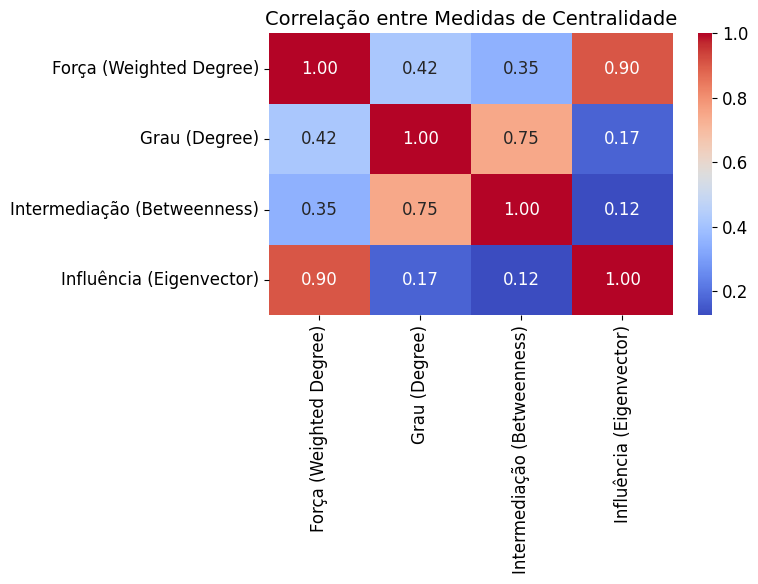


Tabela completa salva em: 'tabela_centralidades_completa.csv'


In [16]:
# ==============================================================================
# 9. CÁLCULO DE MEDIDAS DE CENTRALIDADE
# ==============================================================================
print(">>> Calculando métricas topológicas da rede...")

# 1. Carregar e Reconstruir o Grafo (Garantia de consistência)
try:
    df_edges = pd.read_csv("rede_coordenacao_final_07_60s.csv")
    G = nx.from_pandas_edgelist(df_edges, 'Source', 'Target', edge_attr='Weight')
    
    # Carregar comunidades para contexto
    df_comm = pd.read_csv("nos_e_comunidades.csv")
    # Cria dicionário para mapear ID -> Comunidade rápido
    dict_comm = pd.Series(df_comm.community_id.values, index=df_comm.user_id.astype(str)).to_dict()

except Exception as e:
    print(f"Erro ao carregar arquivos: {e}")
    raise

# 2. Calcular as Centralidades
# A. Degree Centrality (Normalizado 0-1) - Conectividade
print("Calculando Degree Centrality...")
deg_cent = nx.degree_centrality(G)

# B. Betweenness Centrality - O "Ponte" / Corretor
# (Calculado sem peso para focar na estrutura da rede)
print("Calculando Betweenness Centrality...")
bet_cent = nx.betweenness_centrality(G, normalized=True)

# C. Eigenvector Centrality - Influência (Conectado a quem é importante)
# (Calculado COM peso, pois conexões fortes importam para influência)
print("Calculando Eigenvector Centrality...")
try:
    eig_cent = nx.eigenvector_centrality(G, weight='Weight', max_iter=1000)
except:
    # Fallback se não convergir
    eig_cent = nx.eigenvector_centrality_numpy(G, weight='Weight')

# D. Weighted Degree (Força Bruta) - Já tínhamos, mas vamos formalizar
# Não é nativo do NX como "centrality", é a soma dos pesos
strength = dict(G.degree(weight='Weight'))

# 3. Consolidar em um DataFrame
df_centralidades = pd.DataFrame({
    'user_id': list(G.nodes()),
    'Grau (Degree)': [deg_cent[n] for n in G.nodes()],
    'Intermediação (Betweenness)': [bet_cent[n] for n in G.nodes()],
    'Influência (Eigenvector)': [eig_cent[n] for n in G.nodes()],
    'Força (Weighted Degree)': [strength[n] for n in G.nodes()]
})

# Adicionar Comunidade
df_centralidades['Comunidade'] = df_centralidades['user_id'].astype(str).map(dict_comm).fillna(-1).astype(int)

# Reordenar colunas
df_centralidades = df_centralidades[['user_id', 'Comunidade', 'Força (Weighted Degree)', 
                                     'Grau (Degree)', 'Intermediação (Betweenness)', 'Influência (Eigenvector)']]

# 4. Exibição dos Top Players por Categoria
print("\n=======================================================")
print("TOP  POR MÉTRICA")
print("=======================================================")

# Top Influenciadores (Eigenvector)
print("\n--- A. Maior Influência (Eigenvector) ---")
print("Estar conectado aos 'chefes'. Quem está no núcleo duro da coordenação.")
print(df_centralidades.sort_values('Influência (Eigenvector)', ascending=False).head(5)[['user_id', 'Comunidade', 'Influência (Eigenvector)']])

# Top Pontes (Betweenness)
print("\n--- B. Maiores Pontes (Betweenness) ---")
print("Usuários que conectam grupos que, de outra forma, estariam separados.")
print(df_centralidades.sort_values('Intermediação (Betweenness)', ascending=False).head(5)[['user_id', 'Comunidade', 'Intermediação (Betweenness)']])

# 5. Correlação entre métricas (Insight Científico)
# Se Grau e Betweenness são muito correlacionados, a rede é centralizada.
# Se são pouco correlacionados, a rede é modular.
plt.figure(figsize=(8, 6))
corr = df_centralidades[['Força (Weighted Degree)', 'Grau (Degree)', 'Intermediação (Betweenness)', 'Influência (Eigenvector)']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlação entre Medidas de Centralidade")
plt.tight_layout()
plt.savefig("matriz_correlacao_centralidades.png")
plt.show()

# 6. Exportar Tabela Final
df_centralidades.to_csv("tabela_centralidades_completa.csv", index=False)
print("\nTabela completa salva em: 'tabela_centralidades_completa.csv'")

### (A) Força (Weighted Degree) × Influência (Eigenvector) → 0.90  Muito alta

Interpretação:

Usuários que interagem muitas vezes também estão conectados a outros usuários muito ativos.

Indica um núcleo denso de coordenação, típico de campanhas organizadas.

Não é apenas volume: é volume dentro do núcleo. Isso fortalece a ideia de “core” coordenado.

### (B) Grau × Intermediação → 0.75 - Alta

Interpretação:

Usuários com muitos contatos tendem também a atuar como pontes entre comunidades. Isso sugere que a difusão entre grupos não é aleatória, mas mediada por atores estruturalmente centrais.

Esses nós são críticos para amplificação e sincronização entre clusters.

### (C) Eigenvector × Betweenness → 0.12 - Muito baixa


Interpretação:

Os usuários mais influentes no núcleo não são os mesmos que conectam comunidades. Há uma separação clara de papéis:

Núcleo → coordena e replica

Pontes → espalham entre grupos

Padrão descrito em literatura de coordenação organizada.

### D) Grau × Eigenvector → 0.17 -  Baixa

Interpretação:

Ter muitos contatos não implica necessariamente ser central no núcleo coordenado.

Refuta a hipótese de que influência é apenas “quem fala com mais gente”.

In [17]:
# CARACTERIZAÇÃO SEMÂNTICA (BERTopic)

# 1. Carregar e Preparar Dados
try:
    if 'df' not in locals():
        df = pd.read_csv("dataset_zap_1_preprocessado.csv")
    
    df_comunidades = pd.read_csv("nos_e_comunidades.csv")
    
    # Converter IDs para string
    df['id_member_anonymous'] = df['id_member_anonymous'].astype(str)
    df_comunidades['user_id'] = df_comunidades['user_id'].astype(str)

    # MERGE: Apenas mensagens de usuários da rede
    df_coordenado = df.merge(df_comunidades, left_on='id_member_anonymous', right_on='user_id', how='inner')
    
    print(f"Total de mensagens de usuários coordenados: {len(df_coordenado)}")
    
except Exception as e:
    print(f"Erro ao preparar dados: {e}")
    raise

# 2. Configurar BERTopic
print("Treinando modelo de tópicos (isso pode demorar alguns minutos)...")

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

topic_model = BERTopic(
    language="multilingual", 
    umap_model=umap_model, 
    hdbscan_model=hdbscan_model,
    min_topic_size=10, 
    verbose=True
)

# 3. Treinar e Transformar
docs = df_coordenado['clean_text'].tolist()
topics, probs = topic_model.fit_transform(docs)

# ==============================================================================
# 3.1. LIMPEZA PÓS-TREINO (A SOLUÇÃO PARA O SEU GRÁFICO)
# ==============================================================================
print("Atualizando representação dos tópicos para remover ruídos visuais...")

# token_pattern=r'\b\w{2,20}\b': 
# Mantém apenas palavras que tenham entre 2 e 20 caracteres. 
# Isso elimina descrições de emojis longas (ex: 'backhandindexpointing...') 
# e repetições exageradas.
vectorizer_model = CountVectorizer(token_pattern=r'\b\w{2,20}\b')

# Atualiza os tópicos com essa nova regra sem precisar retreinar a redução de dimensionalidade
topic_model.update_topics(docs, vectorizer_model=vectorizer_model)
# ==============================================================================


# 4. Exibir Resultados Gerais
print("\n>>> Tópicos Gerais Encontrados (Pós-Limpeza):")
freq = topic_model.get_topic_info()
print(freq.head(10)) 

# 5. Tópicos por Comunidade
print("\n>>> Análise por Comunidade (O que cada grupo fala?):")
top_comunidades = df_coordenado['community_id'].value_counts().head(5).index
topics_per_class = topic_model.topics_per_class(docs, classes=df_coordenado['community_id'])

for comm_id in top_comunidades:
    print(f"\n--- Comunidade {comm_id} ---")
    specific_topics = topics_per_class[topics_per_class['Class'] == comm_id].sort_values('Frequency', ascending=False).head(3)
    
    for _, row in specific_topics.iterrows():
        topic_num = row['Topic']
        if topic_num == -1: continue
        
        words = [word for word, _ in topic_model.get_topic(topic_num)][:5]
        print(f"Tópico {topic_num} ({row['Frequency']} msgs): {', '.join(words)}")

# 6. Salvar Visualização de Tópicos
# Adicionei n_words=5 e width/height para garantir que o gráfico fique legível
fig = topic_model.visualize_barchart(top_n_topics=10, n_words=5, width=1000)
fig.write_html("topicos_barras.html")
print("\nGráfico de tópicos salvo em 'topicos_barras.html'")

2025-12-25 10:07:30,024 - BERTopic - Embedding - Transforming documents to embeddings.


Total de mensagens de usuários coordenados: 30976
Treinando modelo de tópicos (isso pode demorar alguns minutos)...


Batches:   0%|          | 0/968 [00:00<?, ?it/s]

2025-12-25 10:07:59,353 - BERTopic - Embedding - Completed ✓
2025-12-25 10:07:59,355 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-25 10:09:46,444 - BERTopic - Dimensionality - Completed ✓
2025-12-25 10:09:46,451 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-25 10:09:50,602 - BERTopic - Cluster - Completed ✓
2025-12-25 10:09:50,620 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-25 10:09:51,672 - BERTopic - Representation - Completed ✓


Atualizando representação dos tópicos para remover ruídos visuais...

>>> Tópicos Gerais Encontrados (Pós-Limpeza):
   Topic  Count                                               Name  \
0     -1   8280             -1_jb_preso_portalcidadenews_carlinhos   
1      0    364                           0_olha_vou_repassar_oque   
2      1    306            1_youtube_youtubecom_tvrádio_videozinho   
3      2    138                     2_mídia_velha_redações_johnson   
4      3    121      3_userbrazil_continuem_esclarecedor_favoritos   
5      4    114                 4_userbrazil_canal_missionário_out   
6      5    110  5_youtube_thinkingfaceyoutube_cena_brazilthumbsup   
7      6    109                    6_vheloappcom_toque_ver_acessem   
8      7    104                 7_userbrazil_olêu_canal_reeducação   
9      8    101               8_jefferson_roberto_prisão_atingidos   

                                      Representation  \
0  [jb, preso, portalcidadenews, carlinhos, veja,...   
1

51it [00:04, 12.08it/s]



--- Comunidade 2 ---
Tópico 12 (68 msgs): apelaram, criada, news, fake, gastou
Tópico 32 (68 msgs): reza, crescerá, aplaudido, colo, aparecida

--- Comunidade 9 ---
Tópico 4 (110 msgs): userbrazil, canal, missionário, out, supermercados
Tópico 3 (106 msgs): userbrazil, continuem, esclarecedor, favoritos, ps

--- Comunidade 25 ---
Tópico 45 (40 msgs): agenda, semanal, presidência, 2310, candidatura
Tópico 93 (36 msgs): estúdios, manifesto, épico, enaltece, desfiliação

--- Comunidade 6 ---
Tópico 62 (52 msgs): passava, universitário, perito, pf, desviar
Tópico 56 (50 msgs): agenda, presidência, candidatos, sexta, confira

--- Comunidade 30 ---
Tópico 1 (74 msgs): youtube, youtubecom, tvrádio, videozinho, ís
Tópico 103 (30 msgs): física, temor, distribuir, explicar, integridade

Gráfico de tópicos salvo em 'topicos_barras.html'


In [18]:
# Ajustes para artigo:
# title: Um título geral mais adequado
fig = topic_model.visualize_barchart(
    top_n_topics=4, 
    n_words=6, 
    width=1200, 
    height=500,
    title="Principais Tópicos e Palavras-chave Associadas"
)

fig.update_xaxes(showticklabels=False, title_text=None, showgrid=False)

# Ajustar layout para ficar mais compacto
fig.update_layout(
    margin=dict(t=60, b=20, l=20, r=20), # Margens menores
    font=dict(size=14) # Fonte um pouco maior para leitura
)

# Salvar em HTML (para interativo)
fig.write_html("topicos_artigo_limpo.html")
print("Gráfico HTML salvo.")

# --- PARA ARTIGO ---
fig.write_image("topicos_artigo_v1.png", scale=3, width=1200, height=500)

Gráfico HTML salvo.


In [19]:

# ==============================================================================
# ANÁLISE DE DESINFORMAÇÃO E RANKINGS
# ==============================================================================
print(">>> Iniciando Análise de Métricas de Desinformação e Influência...")

try:
    # 1. CARREGAR DADOS
    # Mensagens originais (com score de desinformação)
    df_msgs = pd.read_csv("dataset_zap_1_preprocessado.csv")
    
    # Comunidades (Quem é de qual grupo)
    df_comm = pd.read_csv("nos_e_comunidades.csv")
    
    # Rede (Para pegar o Peso/Força de coordenação)
    df_edges = pd.read_csv("rede_coordenacao_final_07_60s.csv")

    # 2. PREPARAR DADOS DE PESO (Weighted Degree)
    # O "Peso" de um usuário é a soma de todas as suas conexões fortes
    # Isso indica o quão "pesado" ele é na coordenação
    peso_origem = df_edges.groupby('Source')['Weight'].sum()
    peso_destino = df_edges.groupby('Target')['Weight'].sum()
    df_pesos = (peso_origem.add(peso_destino, fill_value=0)).reset_index()
    df_pesos.columns = ['user_id', 'peso_coordenacao']
    
    # Converter IDs para string para garantir merge
    df_msgs['id_member_anonymous'] = df_msgs['id_member_anonymous'].astype(str)
    df_comm['user_id'] = df_comm['user_id'].astype(str)
    df_pesos['user_id'] = df_pesos['user_id'].astype(str)

    # 3. MERGE FINAL (Tudo em um lugar só)
    # Juntamos mensagens + comunidade + peso do usuário
    df_full = df_msgs.merge(df_comm, left_on='id_member_anonymous', right_on='user_id', how='inner')
    df_full = df_full.merge(df_pesos, on='user_id', how='left')
    
    print(f"Base consolidada: {len(df_full)} mensagens de usuários coordenados.")

    # --------------------------------------------------------------------------
    # A. MÉDIA DE DESINFORMAÇÃO POR COMUNIDADE
    # --------------------------------------------------------------------------
    print("\n--- A. Ranking de Desinformação por Comunidade ---")
    
    # Verifica se a coluna existe (para evitar erro)
    col_score = 'score_misinformation' 
    if col_score not in df_full.columns:
        print(f"AVISO: Coluna '{col_score}' não encontrada. Usando dados simulados ou pule esta etapa.")
        # Se não tiver, crie ou pule. Aqui vou assumir que existe.
    else:
        # Agrupa por comunidade e calcula média
        misinfo_comm = df_full.groupby('community_id')[col_score].agg(['mean', 'count', 'std'])
        misinfo_comm = misinfo_comm.sort_values('mean', ascending=False)
        
        print(misinfo_comm.head(5))
        misinfo_comm.to_csv("relatorio_desinformacao_comunidades.csv")

    # --------------------------------------------------------------------------
    # B. TOP 5 MENSAGENS POR COMUNIDADE
    # --------------------------------------------------------------------------
    print("\n--- B. Top 5 Mensagens Mais Compartilhadas por Comunidade ---")
    
    top_comunidades = df_full['community_id'].value_counts().head(5).index
    
    for comm_id in top_comunidades:
        print(f"\n[Comunidade {comm_id}]")
        subset = df_full[df_full['community_id'] == comm_id]
        
        # Conta mensagens repetidas (texto limpo)
        top_msgs = subset['clean_text'].value_counts().head(5)
        
        for txt, count in top_msgs.items():
            print(f"({count}x): {txt[:100]}...") # Mostra só os primeiros 100 caracteres
except Exception as e:
    print(f"Erro na análise: {e}")

>>> Iniciando Análise de Métricas de Desinformação e Influência...
Base consolidada: 30976 mensagens de usuários coordenados.

--- A. Ranking de Desinformação por Comunidade ---
                  mean  count       std
community_id                           
22            0.780286      7  0.232475
26            0.696556    111  0.272210
23            0.642114    105  0.265711
11            0.595796     44  0.373003
37            0.593206     94  0.297150

--- B. Top 5 Mensagens Mais Compartilhadas por Comunidade ---

[Comunidade 2]
(30x): brasil moraes protege institutos pesquisa fraude eleitoral contra bolsonaro continuará gustavo gayer...
(25x): mundo esquerda poder venezuela fecha 15 rádios semana pingos is assista pensandodireitacom...
(24x): brasil país recebeu quase 85 mil venezuelanos fugiram socialismo pingos is assista pensandodireitaco...
(18x): brasil imprensa desmentida pec quer aumentar ministros stf verdade esquerdista pingos is assista pen...
(18x): brasil amanda klein de

In [20]:
# ==============================================================================
# C. TOP 5 USUÁRIOS POR COMUNIDADE + MENSAGEM PRINCIPAL (CORRIGIDO)
# ==============================================================================

# Verifica se os dados já foram carregados na memória
if 'df_full' in locals() and 'top_comunidades' in locals():
    print("\n--- C. Top 5 Usuários Mais Ativos e Suas 'Armas' Principais ---")

    for comm_id in top_comunidades:
        print(f"\n[Comunidade {comm_id}]")
        
        # Filtra dados apenas dessa comunidade
        subset_comm = df_full[df_full['community_id'] == comm_id]
        
        # 1. Identificar os Top Usuários pelo Peso (Weight)
        # Drop duplicates para não pegar o mesmo usuário várias vezes na listagem
        users_unique = subset_comm[['user_id', 'peso_coordenacao', 'degree']].drop_duplicates()
        top_users = users_unique.sort_values('peso_coordenacao', ascending=False).head(5)
        
        # Itera sobre os top 5 usuários
        for _, row in top_users.iterrows():
            uid = row['user_id']
            peso = row['peso_coordenacao']
            grau = row['degree']
            
            # 2. Descobrir a mensagem mais repetida POR ESSE USUÁRIO
            # Filtra todas as mensagens enviadas por este usuário específico
            msgs_do_user = subset_comm[subset_comm['user_id'] == uid]['clean_text']
            
            if not msgs_do_user.empty:
                # Pega a mensagem mais frequente (Top 1)
                top_msg_count = msgs_do_user.value_counts()
                texto_principal = top_msg_count.index[0]
                qtd_repeticoes = top_msg_count.iloc[0]
                
                # Tratamento de string para exibição (remove quebras de linha e limita tamanho)
                texto_limpo = str(texto_principal).replace('\n', ' ')
                display_text = texto_limpo[:100] + "..." if len(texto_limpo) > 100 else texto_limpo
            else:
                display_text = "[Sem texto identificado]"
                qtd_repeticoes = 0
            
            # 3. Exibir Relatório do Usuário
            print(f"User {str(uid)[:6]}... | Peso: {peso:.0f} | Grau: {grau}")
            print(f"   └── Msg Principal ({qtd_repeticoes}x): {display_text}")

else:
    print("ERRO: As variáveis 'df_full' ou 'top_comunidades' não estão na memória.")
    print("Por favor, rode o bloco anterior (Parte A e B) antes de rodar este.")


--- C. Top 5 Usuários Mais Ativos e Suas 'Armas' Principais ---

[Comunidade 2]
User cebd21... | Peso: 127 | Grau: 7
   └── Msg Principal (12x): mundo esquerda poder venezuela fecha 15 rádios semana pingos is assista pensandodireitacom
User b62423... | Peso: 72 | Grau: 4
   └── Msg Principal (8x): brasil moraes protege institutos pesquisa fraude eleitoral contra bolsonaro continuará gustavo gayer...
User 19654c... | Peso: 60 | Grau: 3
   └── Msg Principal (8x): brasil imprensa desmentida pec quer aumentar ministros stf verdade esquerdista pingos is assista pen...
User 0f6014... | Peso: 40 | Grau: 4
   └── Msg Principal (6x): brasil moraes protege institutos pesquisa fraude eleitoral contra bolsonaro continuará gustavo gayer...
User 078864... | Peso: 9 | Grau: 2
   └── Msg Principal (1x): indexpointingupindexpointingupindexpointingupindexpointingupindexpointingup pior regimes nazicomunif...

[Comunidade 9]
User 32bc3d... | Peso: 17 | Grau: 4
   └── Msg Principal (8x): quadrilheiro josé

In [21]:
import pandas as pd
from textblob import TextBlob

# ==============================================================================
# C. TABELA DE PERFIL: TOP USUÁRIOS + MENSAGENS + MÉTRICAS
# ==============================================================================

if 'df_full' in locals() and 'top_comunidades' in locals():
    print(">>> Gerando tabela consolidada de líderes e narrativas...")
    
    # Lista para armazenar as linhas da tabela
    tabela_dados = []

    for comm_id in top_comunidades:
        # Filtra dados apenas dessa comunidade
        subset_comm = df_full[df_full['community_id'] == comm_id]
        
        # 1. Identificar Top Usuários (Pelo 'Peso' de coordenação)
        users_unique = subset_comm[['user_id', 'peso_coordenacao', 'degree']].drop_duplicates()
        top_users = users_unique.sort_values('peso_coordenacao', ascending=False).head(5)
        
        for _, row in top_users.iterrows():
            uid = row['user_id']
            peso = row['peso_coordenacao']
            grau = row['degree']
            
            # 2. Descobrir a mensagem mais repetida
            msgs_do_user_df = subset_comm[subset_comm['user_id'] == uid]
            
            if not msgs_do_user_df.empty:
                # Top 1 mensagem
                top_msg_count = msgs_do_user_df['clean_text'].value_counts()
                texto_principal = top_msg_count.index[0]
                qtd_repeticoes = top_msg_count.iloc[0]
                
                # A. Score de Desinformação (Média)
                score_misinfo = msgs_do_user_df[msgs_do_user_df['clean_text'] == texto_principal]['score_misinformation'].mean()
                
                # B. Score de Sentimento (TextBlob)
                blob = TextBlob(str(texto_principal))
                score_sentimento = blob.sentiment.polarity
                
                # Classificação simples do sentimento para leitura rápida
                if score_sentimento > 0.1: class_sent = "Positivo"
                elif score_sentimento < -0.1: class_sent = "Negativo"
                else: class_sent = "Neutro"

                # Truncar texto para a tabela não quebrar
                texto_limpo = str(texto_principal).replace('\n', ' ').replace('\r', '')
                msg_curta = texto_limpo[:80] + "..." if len(texto_limpo) > 80 else texto_limpo
                
            else:
                msg_curta = "N/A"
                qtd_repeticoes = 0
                score_misinfo = 0.0
                score_sentimento = 0.0
                class_sent = "N/A"

            # 3. Adicionar dados à lista
            tabela_dados.append({
                'Comunidade': comm_id,
                'User_ID': str(uid)[:8], # ID encurtado para visualização
                'Peso_Coord': int(peso),
                'Grau_Conexoes': int(grau),
                'Repeticoes_Msg': int(qtd_repeticoes),
                'Score_Desinfo': round(score_misinfo, 2),
                'Score_Sentimento': round(score_sentimento, 2),
                'Class_Sentimento': class_sent,
                'Mensagem_Principal': msg_curta
            })

    # 4. Criar DataFrame final
    df_relatorio = pd.DataFrame(tabela_dados)

    # Exibir a tabela formatada (Se estiver no Jupyter/Colab, usa o display bonito)
    try:
        from IPython.display import display
        # Aplica um gradiente de cor na coluna de Desinformação (Vermelho = Alto)
        display(df_relatorio.style.background_gradient(subset=['Score_Desinfo'], cmap='Reds'))
    except:
        print(df_relatorio)

    # 5. Exportar para CSV (Opcional, para usar no TCC)
    df_relatorio.to_csv("relatorio_lideres_comunidades.csv", index=False)
    print("\nArquivo 'relatorio_lideres_comunidades.csv' salvo com sucesso.")

else:
    print("ERRO: Variáveis necessárias não carregadas.")

>>> Gerando tabela consolidada de líderes e narrativas...


,Comunidade,User_ID,Peso_Coord,Grau_Conexoes,Repeticoes_Msg,Score_Desinfo,Score_Sentimento,Class_Sentimento,Mensagem_Principal
0,2,cebd2107,127,7,12,nan,0.000000,Neutro,mundo esquerda poder venezuela fecha 15 rádios semana pingos is assista pensando...
1,2,b6242381,72,4,8,nan,0.000000,Neutro,brasil moraes protege institutos pesquisa fraude eleitoral contra bolsonaro cont...
2,2,19654cb7,60,3,8,0.170000,0.000000,Neutro,brasil imprensa desmentida pec quer aumentar ministros stf verdade esquerdista p...
3,2,0f601498,40,4,6,nan,0.000000,Neutro,brasil moraes protege institutos pesquisa fraude eleitoral contra bolsonaro cont...
4,2,07886446,9,2,1,nan,0.000000,Neutro,indexpointingupindexpointingupindexpointingupindexpointingupindexpointingup pior...
5,9,32bc3dcc,17,4,8,nan,0.000000,Neutro,quadrilheiro josé dirceu teme preso caso lula perca eleições deste ano portalcid...
6,9,cd45e9e7,16,4,8,0.520000,0.000000,Neutro,backhandindexpointingup assim presidente user recebe 88 votos certinhos todas se...
7,9,bf19c62b,6,3,10,nan,0.000000,Neutro,regime lula quer brasil mostre povo lula consegue enganar
8,9,67c7dc33,5,2,1,0.000000,0.000000,Neutro,15ª semana preço gasolina recua chega 479 postos diesel queda 06 atingiu 652 eta...
9,9,7ecca0bb,4,2,3,nan,0.000000,Neutro,pt obtém liminar diminui período plantio soja mato grosso revistaoestecom



Arquivo 'relatorio_lideres_comunidades.csv' salvo com sucesso.


In [22]:
import pandas as pd
from textblob import TextBlob

# ==============================================================================
# C. TABELA AVANÇADA: LÍDERES + ALCANCE DE GRUPOS (SPREAD)
# ==============================================================================

if 'df_full' in locals() and 'top_comunidades' in locals():
    print(">>> Gerando tabela de disseminação e alcance de grupos...")
    
    # Verifica se a coluna de grupo existe (ajuste o nome se for diferente no seu CSV)
    col_grupo = 'id_group_anonymous' 
    if col_grupo not in df_full.columns:
        # Tenta achar nomes comuns caso tenha mudado
        possible_cols = [c for c in df_full.columns if 'group' in c or 'grupo' in c]
        if possible_cols:
            col_grupo = possible_cols[0]
            print(f"Aviso: Usando coluna '{col_grupo}' para identificar grupos.")
        else:
            print("ERRO: Coluna de ID do grupo não encontrada.")
    
    tabela_dados = []

    for comm_id in top_comunidades:
        # Filtra dados da comunidade
        subset_comm = df_full[df_full['community_id'] == comm_id]
        
        # 1. Identificar Top Usuários
        users_unique = subset_comm[['user_id', 'peso_coordenacao', 'degree']].drop_duplicates()
        top_users = users_unique.sort_values('peso_coordenacao', ascending=False).head(5)
        
        for _, row in top_users.iterrows():
            uid = row['user_id']
            peso = row['peso_coordenacao']
            grau = row['degree']
            
            # 2. Descobrir a mensagem principal
            msgs_do_user_df = subset_comm[subset_comm['user_id'] == uid]
            
            if not msgs_do_user_df.empty:
                top_msg_count = msgs_do_user_df['clean_text'].value_counts()
                texto_principal = top_msg_count.index[0]
                qtd_repeticoes = top_msg_count.iloc[0]
                
                # --- NOVAS MÉTRICAS DE GRUPO ---
                
                # A. Em quantos grupos ESSE USUÁRIO jogou essa mensagem?
                # Filtra: (Usuário Certo) E (Texto Certo) -> Conta Grupos Únicos
                subset_user_msg = msgs_do_user_df[msgs_do_user_df['clean_text'] == texto_principal]
                grupos_user = subset_user_msg[col_grupo].nunique()
                
                # B. Em quantos grupos ESSA MENSAGEM circulou NO TOTAL (na comunidade)?
                # Filtra: (Texto Certo) em toda a comunidade -> Conta Grupos Únicos
                subset_total_msg = subset_comm[subset_comm['clean_text'] == texto_principal]
                grupos_total = subset_total_msg[col_grupo].nunique()
                
                # --- SCORES (Mantidos) ---
                score_misinfo = subset_user_msg['score_misinformation'].mean()
                blob = TextBlob(str(texto_principal))
                score_sentimento = blob.sentiment.polarity
                
                if score_sentimento > 0.1: class_sent = "Positivo"
                elif score_sentimento < -0.1: class_sent = "Negativo"
                else: class_sent = "Neutro"

                # Formatação texto
                texto_limpo = str(texto_principal).replace('\n', ' ').replace('\r', '')
                msg_curta = texto_limpo[:60] + "..." if len(texto_limpo) > 60 else texto_limpo
                
            else:
                msg_curta = "N/A"
                qtd_repeticoes = 0
                grupos_user = 0
                grupos_total = 0
                score_misinfo = 0.0
                score_sentimento = 0.0
                class_sent = "N/A"

            # 3. Adicionar à tabela
            tabela_dados.append({
                'Comunidade': comm_id,
                'User_ID': str(uid)[:8],
                'Peso_Coord': int(peso),
                'Repeticoes': int(qtd_repeticoes),
                'Grupos_User': int(grupos_user),    # Quantos grupos o usuário atingiu
                'Grupos_Total': int(grupos_total),  # Viralidade total da mensagem
                'Score_Desinfo': round(score_misinfo, 2),
                'Class_Sentimento': class_sent,
                'Mensagem_Principal': msg_curta
            })

    # 4. Exibir DataFrame
    df_relatorio = pd.DataFrame(tabela_dados)
    
    # Reordenar colunas para facilitar leitura
    cols_order = ['Comunidade', 'User_ID', 'Peso_Coord', 'Repeticoes', 
                  'Grupos_User', 'Grupos_Total', 'Score_Desinfo', 'Class_Sentimento', 'Mensagem_Principal']
    df_relatorio = df_relatorio[cols_order]

    # Display com gradiente nos grupos (Verde escuro = atingiu muitos grupos)
    try:
        from IPython.display import display
        display(df_relatorio.style.background_gradient(subset=['Grupos_User'], cmap='Greens'))
    except:
        print(df_relatorio)

    # Exportar
    df_relatorio.to_csv("relatorio_superdisseminadores_grupos.csv", index=False)
    print("\nArquivo salvo: 'relatorio_superdisseminadores_grupos.csv'")

else:
    print("ERRO: Variáveis 'df_full' ou 'top_comunidades' não carregadas.")

>>> Gerando tabela de disseminação e alcance de grupos...


,Comunidade,User_ID,Peso_Coord,Repeticoes,Grupos_User,Grupos_Total,Score_Desinfo,Class_Sentimento,Mensagem_Principal
0,2,cebd2107,127,12,6,15,nan,Neutro,mundo esquerda poder venezuela fecha 15 rádios semana pingos...
1,2,b6242381,72,8,4,15,nan,Neutro,brasil moraes protege institutos pesquisa fraude eleitoral c...
2,2,19654cb7,60,8,4,9,0.170000,Neutro,brasil imprensa desmentida pec quer aumentar ministros stf v...
3,2,0f601498,40,6,3,15,nan,Neutro,brasil moraes protege institutos pesquisa fraude eleitoral c...
4,2,07886446,9,1,1,1,nan,Neutro,indexpointingupindexpointingupindexpointingupindexpointingup...
5,9,32bc3dcc,17,8,4,4,nan,Neutro,quadrilheiro josé dirceu teme preso caso lula perca eleições...
6,9,cd45e9e7,16,8,2,2,0.520000,Neutro,backhandindexpointingup assim presidente user recebe 88 voto...
7,9,bf19c62b,6,10,3,3,nan,Neutro,regime lula quer brasil mostre povo lula consegue enganar
8,9,67c7dc33,5,1,1,1,0.000000,Neutro,15ª semana preço gasolina recua chega 479 postos diesel qued...
9,9,7ecca0bb,4,3,1,1,nan,Neutro,pt obtém liminar diminui período plantio soja mato grosso re...



Arquivo salvo: 'relatorio_superdisseminadores_grupos.csv'


>>> Iniciando Análise Temporal e de Grupos...
Gerando gráfico de evolução temporal...


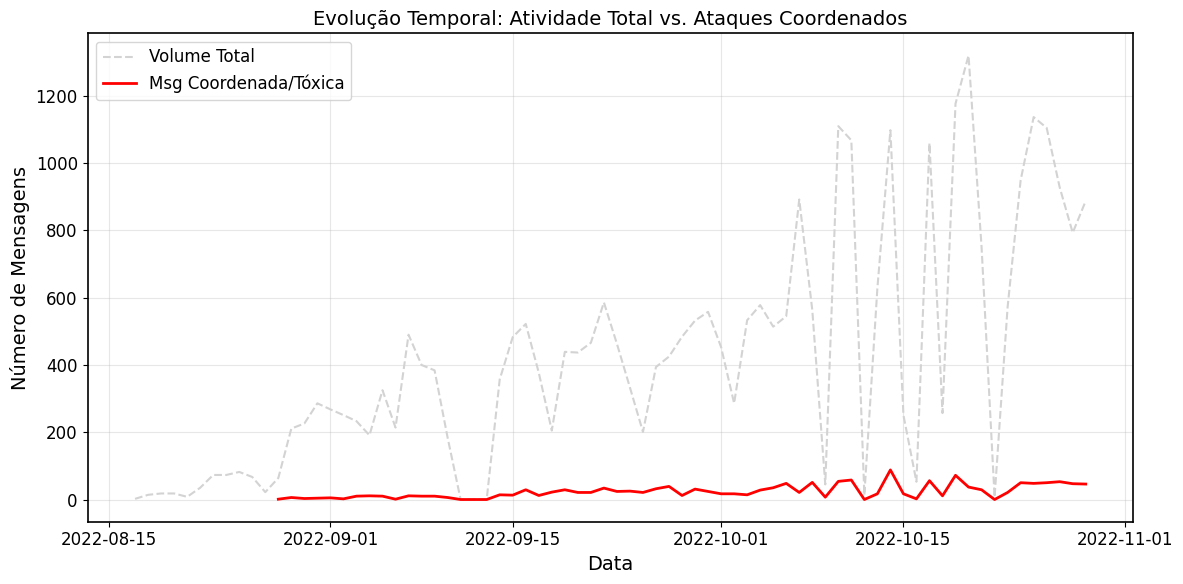

Gráfico salvo: 'timeline_coordenacao.png'

Gerando classificação dos grupos (Command Centers vs. Alvos)...

--- TOP 10 GRUPOS 'QUARTEL GENERAL' (Maior taxa de Fake News) ---
                             Group_ID  Qtd_Usuarios  Vol_Msgs  Taxa_Desinfo
84   c014e1c0fb75f0e00ac6680c028b2848             1        10      0.786231
70   a5910d5cc1c830ade9eb4dd00f15ff6a             1        22      0.766680
100  df21045c60237267a50a4a11d927a98b             1        66      0.679394
56   80f99339efa1d5aeddb1813496ec2181             1        78      0.644390
90   c5cd4928ae5f66efc043f1fa9feec540             1         7      0.629166
106  fda31d27ad6c53c2c2c9854f0e853ae4             1        11      0.591198
98   dad0c53233383b2a10de621b815dfe8e             2        48      0.575107
17   3aeb0bf6eae749a13dd6c8b020ed9a66             2       524      0.536038
14   30655974cefd48418b8ab8f2521b4273             1        25      0.532389
6    1342d65a3de7582a0d3a4b56a0e3ac29             1         1     

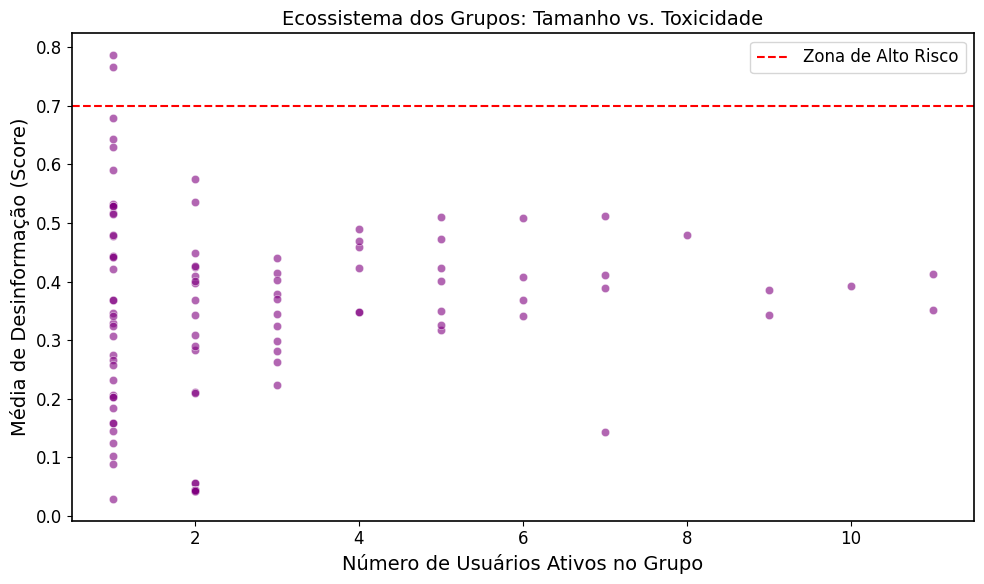

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 10. ANÁLISES FINAIS: TEMPORAL E ESTRUTURAL DE GRUPOS
# ==============================================================================

if 'df_full' in locals():
    print(">>> Iniciando Análise Temporal e de Grupos...")

    # Garante que temos data/hora
    # Tenta usar colunas comuns de timestamp. Ajuste se o nome for diferente.
    col_tempo = 'created_at' if 'created_at' in df_full.columns else 'date_message'
    
    # Converter para datetime
    df_full[col_tempo] = pd.to_datetime(df_full[col_tempo])
    
    # --------------------------------------------------------------------------
    # A. TIMELINE DA COORDENAÇÃO (QUANDO OCORREU?)
    # --------------------------------------------------------------------------
    print("Gerando gráfico de evolução temporal...")
    
    # Agrupar por Dia (ou Hora, se o período for curto. Use 'H' para hora, 'D' para dia)
    freq = 'D' 
    
    # 1. Volume Total de Mensagens (Background)
    vol_total = df_full.set_index(col_tempo).resample(freq).size()
    
    # 2. Volume de Mensagens Tóxicas/Coordenadas (Alta Desinformação)
    # Filtra mensagens que são coordenadas E têm score de desinformação alto
    mask_toxico = df_full['score_misinformation'] >= 0.7
    vol_toxico = df_full[mask_toxico].set_index(col_tempo).resample(freq).size()
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(vol_total.index, vol_total.values, label='Volume Total', color='lightgray', linestyle='--')
    plt.plot(vol_toxico.index, vol_toxico.values, label='Msg Coordenada/Tóxica', color='red', linewidth=2)
    
    plt.title("Evolução Temporal: Atividade Total vs. Ataques Coordenados")
    plt.ylabel("Número de Mensagens")
    plt.xlabel("Data")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("timeline_coordenacao.png")
    plt.show()
    print("Gráfico salvo: 'timeline_coordenacao.png'")

    # --------------------------------------------------------------------------
    # B. PAPEL DOS GRUPOS (ONDE OCORREU?)
    # --------------------------------------------------------------------------
    print("\nGerando classificação dos grupos (Command Centers vs. Alvos)...")
    
    col_grupo = 'id_group_anonymous' # Ajuste se necessário
    
    if col_grupo in df_full.columns:
        # Para cada grupo, calculamos:
        # 1. Total de mensagens recebidas
        # 2. Total de usuários únicos
        # 3. Taxa de Desinformação (Média do score)
        
        stats_grupos = df_full.groupby(col_grupo).agg({
            'user_id': 'nunique',           # Quantas pessoas falam lá
            'clean_text': 'count',          # Volume de msgs
            'score_misinformation': 'mean'  # O quão tóxico é o grupo
        }).reset_index()
        
        stats_grupos.columns = ['Group_ID', 'Qtd_Usuarios', 'Vol_Msgs', 'Taxa_Desinfo']
        
        # Classificação Simples
        # Grupos Tóxicos: Alta Desinformação (> 0.7)
        # Grupos Populares: Muitos Usuários (> média)
        
        top_grupos_toxicos = stats_grupos.sort_values('Taxa_Desinfo', ascending=False).head(10)
        
        print("\n--- TOP 10 GRUPOS 'QUARTEL GENERAL' (Maior taxa de Fake News) ---")
        print(top_grupos_toxicos)
        
        # Salvar
        stats_grupos.to_csv("analise_grupos_metricas.csv", index=False)
        print("\nTabela de grupos salva em 'analise_grupos_metricas.csv'")
        
        # Gráfico de Dispersão: Tamanho do Grupo vs. Toxicidade
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=stats_grupos, x='Qtd_Usuarios', y='Taxa_Desinfo', alpha=0.6, color='purple')
        plt.axhline(0.7, color='red', linestyle='--', label='Zona de Alto Risco')
        plt.title("Ecossistema dos Grupos: Tamanho vs. Toxicidade")
        plt.xlabel("Número de Usuários Ativos no Grupo")
        plt.ylabel("Média de Desinformação (Score)")
        plt.legend()
        plt.tight_layout()
        plt.savefig("scatter_grupos.png")
        plt.show()

else:
    print("DF Full não carregado.")

In [24]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from ipysigma import Sigma

# ==============================================================================
# VISUALIZAÇÃO IPYSIGMA - CORRIGIDO (VERSÃO FINAL)
# ==============================================================================
print(">>> Gerando visualização estilo Gephi (ForceAtlas2)...")

if 'G' in locals() and 'partition' in locals():
    
    # 1. Preparação dos Dados
    nx.set_node_attributes(G, partition, 'comunidade')
    
    # Adicionar Grau Ponderado (Tamanho)
    weighted_degree = dict(G.degree(weight='Weight'))
    nx.set_node_attributes(G, weighted_degree, 'tamanho_grau')
    
    # 2. Filtragem (Componentes >= 3)
    components = [c for c in nx.connected_components(G) if len(c) >= 3]
    G_sigma = G.subgraph(set().union(*components))
    
    print(f"Renderizando {G_sigma.number_of_nodes()} nós e {G_sigma.number_of_edges()} arestas...")

    # 3. CRIAR MAPEAMENTO DE CORES MANUAL
    # Gera cores usando Matplotlib (tab20) e converte para HEX
    try:
        cmap = plt.get_cmap('tab20')
    except:
        cmap = plt.cm.tab20 

    unique_communities = set(partition.values())
    color_mapping = {}
    
    for comm_id in unique_communities:
        rgba = cmap(comm_id % 20)
        color_mapping[comm_id] = mcolors.to_hex(rgba)

    # 4. Renderizar com IPYSIGMA
    viz = Sigma(
        G_sigma, 
        
        # --- Aparência dos Nós ---
        node_size='tamanho_grau',
        node_color='comunidade',
        
        # --- CORREÇÃO FINAL AQUI ---
        # O argumento correto é 'node_color_palette', que aceita nosso dicionário
        node_color_palette=color_mapping, 
        
        # --- Layout ---
        start_layout='force_atlas2',
        layout_settings={
            'gravity': 1,
            'scalingRatio': 4, 
            'slowDown': 2
        },
        
        # --- Arestas ---
        edge_size='Weight',
        edge_color='#ccc',
        default_edge_type='curve',
        
        # --- Labels ---
        node_label_size='tamanho_grau', 
        label_font='sans-serif',
        
        # --- Widget ---
        height=800,
        background_color='#111111'
    )

    display(viz)
    print("Dica: Use o ícone de Câmera no canto inferior direito para salvar a imagem.")
    
else:
    print("ERRO: O Grafo G ou a partição não foram carregados.")


>>> Gerando visualização estilo Gephi (ForceAtlas2)...
Renderizando 102 nós e 95 arestas...


Sigma(nx.Graph with 102 nodes and 95 edges)

Dica: Use o ícone de Câmera no canto inferior direito para salvar a imagem.


In [25]:
from ipywidgets.embed import embed_minimal_html
import os

# ==============================================================================
# SALVAR VIA IPYWIDGETS (MÉTODO PADRÃO)
# ==============================================================================
print(">>> Exportando widget para HTML...")

filename = "rede_gephi_final.html"

try:
    # Esta função pega o widget 'viz' e cria um HTML standalone
    embed_minimal_html(filename, views=[viz], title='Rede de Coordenação WhatsApp')
    
    print(f"✅ SUCESSO! Visualização salva em: {filename}")
    print("---------------------------------------------------------------")
    print(f"IMPORTANTE: Vá na pasta do seu projeto.")
    print(f"Abra o arquivo '{filename}' no navegador (Chrome/Edge/Firefox).")
    print("---------------------------------------------------------------")

    # Tenta abrir automaticamente (funciona no Windows)
    try:
        os.startfile(filename)
    except:
        pass

except Exception as e:
    print(f"Erro ao exportar: {e}")
    print("Verifique se 'ipywidgets' está instalado com: !pip install ipywidgets")

>>> Exportando widget para HTML...
✅ SUCESSO! Visualização salva em: rede_gephi_final.html
---------------------------------------------------------------
IMPORTANTE: Vá na pasta do seu projeto.
Abra o arquivo 'rede_gephi_final.html' no navegador (Chrome/Edge/Firefox).
---------------------------------------------------------------


In [26]:

ARQ_EDGES   = "rede_coordenacao_final_07_60s.csv"   # Source, Target, Weight
ARQ_NODES   = "nos_e_comunidades.csv"              # user_id, community_id, degree
ARQ_METRICS = "analise_grupos_metricas.csv"        # métricas por grupo (se quiser cruzar)

edges   = pd.read_csv(ARQ_EDGES)
nodes   = pd.read_csv(ARQ_NODES)
metrics = pd.read_csv(ARQ_METRICS)

print(edges.shape, nodes.shape, metrics.shape)
display(edges.head())
display(nodes.head())
display(metrics.head())

# ==== Monta grafo ponderado ====
G = nx.from_pandas_edgelist(edges, source="Source", target="Target", edge_attr="Weight", create_using=nx.Graph())
print("Nós:", G.number_of_nodes(), "Arestas:", G.number_of_edges())


(129, 3) (170, 3) (107, 4)


,Source,Target,Weight
0,68a3b5285d08206fc1528bae1cca409c,c116c3a7688b5fadef862839d6ea29bb,2
1,63a50fd6a2632596e39599218ca87b1c,9f7b2f9fa6828e155f9350ff48f4038a,3
2,b6242381059f781a69bc6d7b4803c25b,cebd2107ff2001db85851cc0e81e0667,46
3,4b39364bf46e4dd358fe43c0ca23cec4,5710e121c3a6ebfd64b239a6a01e14fc,2
4,c61660f87dda82d308c9afebb2792b3b,f7d465fa0afd2c3237bb3aeca569dbec,2


,user_id,community_id,degree
0,36de514702d7b11e580390df7fbf4fc0,25,8
1,3311fffd95f32b1e78742e7838ea7424,38,8
2,cebd2107ff2001db85851cc0e81e0667,2,7
3,a56ea8882738b3d4c77c64704b1d8244,44,7
4,c5fff63b6151f93e1ce86d12f8acbee1,30,7


,Group_ID,Qtd_Usuarios,Vol_Msgs,Taxa_Desinfo
0,0191a32b325e847ea6f85eac973d4bd1,2,7,0.211150
1,02279b9910329ca9ed5890aa58c68400,1,1,0.528256
2,024cd403f30c0ef80a84aade92114c3a,2,106,0.042858
3,04cd2bacf2ef6d56d4e8c0272752bbc0,11,1123,0.413584
4,0758cf186ed0ebbeb4ed97e378d26fdf,1,142,0.274789


Nós: 170 Arestas: 129


In [27]:
# Core number (coreness) global
core_num = nx.core_number(G)  # dict: user_id -> k
nodes["coreness_global"] = nodes["user_id"].map(core_num).fillna(0).astype(int)

k_max = nodes["coreness_global"].max()
print("k_max (coreness máximo):", k_max)

# Regras de classificação (você pode ajustar):
# - Núcleo global: coreness >= k_max (mais estrito) OU >= k_max-1 (um pouco mais flexível)
nodes["is_core_global"] = (nodes["coreness_global"] >= k_max-1)

display(nodes.sort_values(["coreness_global","degree"], ascending=False).head(10))


k_max (coreness máximo): 3


,user_id,community_id,degree,coreness_global,is_core_global
2,cebd2107ff2001db85851cc0e81e0667,2,7,3,True
9,b6242381059f781a69bc6d7b4803c25b,2,4,3,True
10,0f601498e40c41072042d0f17974d3ba,2,4,3,True
11,19654cb7d7e6914273cb101436032994,2,3,3,True
0,36de514702d7b11e580390df7fbf4fc0,25,8,2,True
5,4ea1b3ee637da811b7d2d0df32db21f9,6,6,2,True
6,cd45e9e743ddcb9a94f61619300539a9,9,4,2,True
7,218131c9ccc6fb6cacc73f2f48927d6b,25,4,2,True
8,32bc3dcc7950c148d4e122043d3d16f3,9,4,2,True
13,de835c6c54fd3057e1dc3b06d49bb139,25,3,2,True


In [46]:
def community_core_periphery(nodes_df, G, community_col="community_id", user_col="user_id"):
    out = []
    for cid, sub in nodes_df.groupby(community_col):
        users = sub[user_col].tolist()
        H = G.subgraph(users).copy()
        if H.number_of_nodes() < 3 or H.number_of_edges() == 0:
            # comunidade pequena/isolada: tudo vira periferia por definição
            tmp = sub.copy()
            tmp["coreness_comm"] = 0
            tmp["is_core_comm"] = False
            out.append(tmp)
            continue

        cnum = nx.core_number(H)
        tmp = sub.copy()
        tmp["coreness_comm"] = tmp[user_col].map(cnum).fillna(0).astype(int)
        kmax = tmp["coreness_comm"].max()

        # Núcleo comunitário: coreness_comm >= (kmax) ou (kmax-1)
        tmp["is_core_comm"] = (tmp["coreness_comm"] >= max(1, kmax-1))
        out.append(tmp)

    return pd.concat(out, ignore_index=True)

nodes2 = community_core_periphery(nodes, G)
display(nodes2.head())

# Resumo por comunidade: tamanho, densidade, % núcleo, coreness max
def community_summary(nodes_df, G):
    rows = []
    for cid, sub in nodes_df.groupby("community_id"):
        users = sub["user_id"].tolist()
        H = G.subgraph(users).copy()
        n = H.number_of_nodes()
        m = H.number_of_edges()
        density = nx.density(H) if n > 1 else 0

        rows.append({
            "community_id": cid,
            "n_users": n,
            "n_edges": m,
            "density": density,
            "kmax_comm": sub["coreness_comm"].max(),
            "core_frac_comm": sub["is_core_comm"].mean(),
            "avg_degree": sub["degree"].mean()
        })

    return pd.DataFrame(rows).sort_values(["n_users","n_edges"], ascending=False)

comm_stats = community_summary(nodes2, G)
display(comm_stats.head(10))

nodes2.to_csv("usuarios_core_periferia_por_comunidade_p1.csv", index=False)
print("Salvo: usuarios_core_periferia_por_comunidade.csv")

,user_id,community_id,degree,coreness_global,is_core_global,coreness_comm,is_core_comm
0,68a3b5285d08206fc1528bae1cca409c,0,1,1,False,0,False
1,c116c3a7688b5fadef862839d6ea29bb,0,1,1,False,0,False
2,63a50fd6a2632596e39599218ca87b1c,1,1,1,False,0,False
3,9f7b2f9fa6828e155f9350ff48f4038a,1,1,1,False,0,False
4,cebd2107ff2001db85851cc0e81e0667,2,7,3,True,3,True


,community_id,n_users,n_edges,density,kmax_comm,core_frac_comm,avg_degree
25,25,13,13,0.166667,2,1.000000,2.230769
38,38,13,12,0.153846,1,1.000000,1.846154
9,9,12,11,0.166667,1,1.000000,2.000000
30,30,9,8,0.222222,1,1.000000,1.888889
44,44,9,8,0.222222,1,1.000000,1.777778
2,2,7,10,0.476190,3,0.714286,3.142857
6,6,5,4,0.400000,1,1.000000,2.000000
10,10,5,4,0.400000,1,1.000000,1.600000
13,13,4,3,0.500000,1,1.000000,1.500000
46,46,4,3,0.500000,1,1.000000,1.500000


Salvo: usuarios_core_periferia_por_comunidade.csv


In [29]:
# === Pluge aqui seu arquivo de localização ===
# Exemplo: usuarios_localizacao.csv com colunas user_id e ddd OU lat/lon
ARQ_LOC = "dataset_zap_1_preprocessado.csv"  # <- troque se necessário

try:
    loc = pd.read_csv(ARQ_LOC)
    display(loc.head())
except FileNotFoundError:
    loc = None
    print("⚠️ Não achei usuarios_localizacao.csv. Sem ele não dá pra mapear DDD/lat-lon.")


,id,date_message,id_member_anonymous,ddi,ddd,country,country_iso3,state,id_group_anonymous,media,...,messenger,media_name,media_md5,display_name,address_message,latitude_message,longitude_message,contacts_message,tokens_preprocessed,clean_text
0,1354213,2022-09-15 18:01:12.000000,f2a32c6d4f0f87af3c9a792a8abfa909,55,32,BRAZIL,BRA,MG,01b05f8760dea7589789b331479ef99d,NaN,...,whatsapp,NaN,NaN,NaN,NaN,0.0,0.0,NaN,"['urgente', 'pesquisa', 'brasmarket', 'aponta'...",urgente pesquisa brasmarket aponta vitória bol...
1,1354214,2022-09-15 18:01:31.000000,355e79047b86581b0950d249ed93e7b0,55,51,BRAZIL,BRA,RS,74d8834c34e6eb033b6f363374e7aca7,NaN,...,whatsapp,NaN,NaN,NaN,NaN,0.0,0.0,NaN,"['youtube', 'brazilbrazilbrazilherbherbherbbra...",youtube brazilbrazilbrazilherbherbherbbrazilbr...
2,1354215,2022-09-15 18:01:37.000000,cd45e9e743ddcb9a94f61619300539a9,55,92,BRAZIL,BRA,AM,b14e237b7d02b836a57692bd2d8fec88,c8450067acc85b9cfc5a708609a9f360.jpeg,...,whatsapp,NaN,c8450067acc85b9cfc5a708609a9f360,NaN,NaN,0.0,0.0,NaN,"['backhandindexpointingup', 'biometria', 'urna...",backhandindexpointingup biometria urnas presid...
3,1354216,2022-09-15 18:01:40.000000,cd45e9e743ddcb9a94f61619300539a9,55,92,BRAZIL,BRA,AM,6fb204781074ea35ab1e957ba150c56f,c8450067acc85b9cfc5a708609a9f360.jpeg,...,whatsapp,NaN,c8450067acc85b9cfc5a708609a9f360,NaN,NaN,0.0,0.0,NaN,"['backhandindexpointingup', 'biometria', 'urna...",backhandindexpointingup biometria urnas presid...
4,1234726,2022-08-17 19:37:51.000000,67c36ae6ee10db35adbf9f9bf1da4f2c,55,21,BRAZIL,BRA,RJ,c5cd4928ae5f66efc043f1fa9feec540,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['lula', 'ontem', '16', 'agosto', 'lançamento'...",lula ontem 16 agosto lançamento campanha bêbad...


In [34]:
# checar se os valores parecem bater
print(nodes2['user_id'].dtype, loc['id_member_anonymous'].dtype)
print(nodes2['user_id'].head(3).tolist())
print(loc['id_member_anonymous'].head(3).tolist())

# quantos users do nodes2 aparecem no loc?
overlap = set(nodes2['user_id']).intersection(set(loc['id_member_anonymous']))
print("Overlap users:", len(overlap), "de", nodes2['user_id'].nunique())


object object
['68a3b5285d08206fc1528bae1cca409c', 'c116c3a7688b5fadef862839d6ea29bb', '63a50fd6a2632596e39599218ca87b1c']
['f2a32c6d4f0f87af3c9a792a8abfa909', '355e79047b86581b0950d249ed93e7b0', 'cd45e9e743ddcb9a94f61619300539a9']
Overlap users: 170 de 170


In [35]:
loc_user = (
    loc.sort_values("date_message")
       .groupby("id_member_anonymous", as_index=False)
       .agg(
           latitude=("latitude", "last"),
           longitude=("longitude", "last"),
           ddd=("ddd", "last"),
           state=("state", "last"),
           country=("country", "last"),
       )
       .rename(columns={"id_member_anonymous": "user_id"})
)


In [36]:
loc_user = (
    loc.groupby("id_member_anonymous", as_index=False)
       .agg(
           latitude=("latitude", "median"),
           longitude=("longitude", "median"),
           ddd=("ddd", lambda x: x.dropna().mode().iloc[0] if len(x.dropna().mode()) else None),
           state=("state", lambda x: x.dropna().mode().iloc[0] if len(x.dropna().mode()) else None),
           country=("country", lambda x: x.dropna().mode().iloc[0] if len(x.dropna().mode()) else None),
       )
       .rename(columns={"id_member_anonymous": "user_id"})
)


In [37]:
nodes_geo = nodes2.merge(loc_user, on="user_id", how="left")
display(nodes_geo.head())
print("Colunas disponíveis:", nodes_geo.columns.tolist())

print("Com lat/lon:", nodes_geo['latitude'].notna().sum(), "/", len(nodes_geo))
print("Com ddd:", nodes_geo['ddd'].notna().sum(), "/", len(nodes_geo))


,user_id,community_id,degree,coreness_global,is_core_global,coreness_comm,is_core_comm,latitude,longitude,ddd,state,country
0,68a3b5285d08206fc1528bae1cca409c,0,1,1,False,0,False,-19.568768,-40.172199,27,ES,BRAZIL
1,c116c3a7688b5fadef862839d6ea29bb,0,1,1,False,0,False,-19.568768,-40.172199,27,ES,BRAZIL
2,63a50fd6a2632596e39599218ca87b1c,1,1,1,False,0,False,-4.479925,-63.518540,92,AM,BRAZIL
3,9f7b2f9fa6828e155f9350ff48f4038a,1,1,1,False,0,False,-4.479925,-63.518540,92,AM,BRAZIL
4,cebd2107ff2001db85851cc0e81e0667,2,7,3,True,3,True,-7.121937,-36.724685,83,PB,BRAZIL


Colunas disponíveis: ['user_id', 'community_id', 'degree', 'coreness_global', 'is_core_global', 'coreness_comm', 'is_core_comm', 'latitude', 'longitude', 'ddd', 'state', 'country']
Com lat/lon: 170 / 170
Com ddd: 167 / 170


In [38]:
summary_comm = (
    nodes_geo.groupby("community_id", as_index=False)
             .agg(
                 n_users=("user_id", "nunique"),
                 n_core=("is_core_comm", "sum"),
                 core_ratio=("is_core_comm", "mean"),
                 median_coreness=("coreness_comm", "median"),
                 lat_ok=("latitude", lambda s: s.notna().sum()),
                 lon_ok=("longitude", lambda s: s.notna().sum()),
                 ddd_ok=("ddd", lambda s: s.notna().sum()),
             )
             .sort_values(["core_ratio","n_users"], ascending=False)
)
display(summary_comm.head(10))


,community_id,n_users,n_core,core_ratio,median_coreness,lat_ok,lon_ok,ddd_ok
25,25,13,13,1.0,1.0,13,13,13
38,38,13,13,1.0,1.0,13,13,12
9,9,12,12,1.0,1.0,12,12,12
30,30,9,9,1.0,1.0,9,9,9
44,44,9,9,1.0,1.0,9,9,9
6,6,5,5,1.0,1.0,5,5,5
10,10,5,5,1.0,1.0,5,5,5
13,13,4,4,1.0,1.0,4,4,4
46,46,4,4,1.0,1.0,4,4,4
5,5,3,3,1.0,1.0,3,3,3


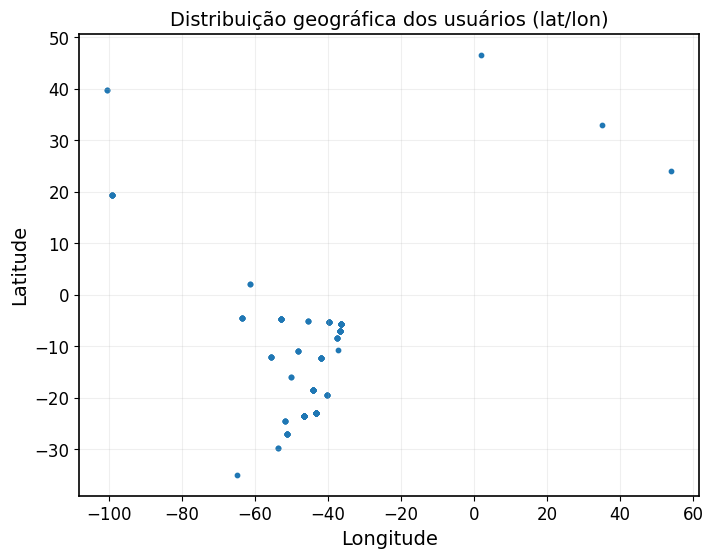

In [39]:
import matplotlib.pyplot as plt

tmp = nodes_geo.dropna(subset=["latitude","longitude"])

plt.figure(figsize=(8,6))
plt.scatter(tmp["longitude"], tmp["latitude"], s=10)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Distribuição geográfica dos usuários (lat/lon)")
plt.grid(True, alpha=0.2)
plt.show()


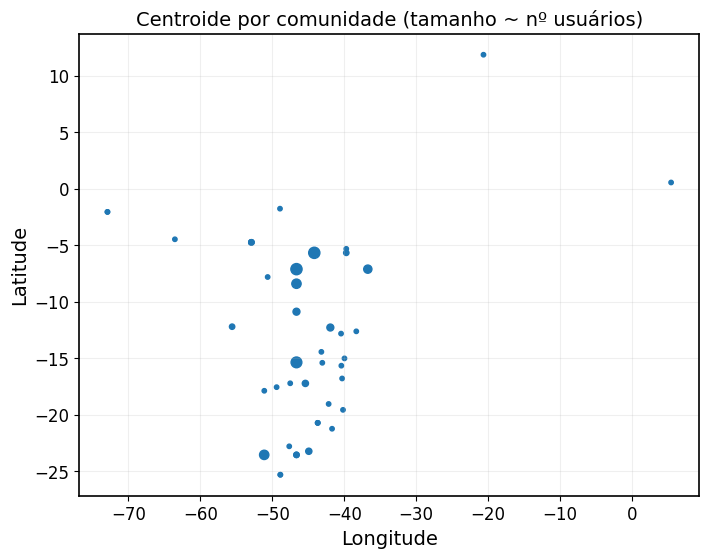

In [40]:
centroids = (
    tmp.groupby("community_id", as_index=False)
       .agg(
           n=("user_id","nunique"),
           lat=("latitude","median"),
           lon=("longitude","median"),
           core_ratio=("is_core_comm","mean")
       )
)

plt.figure(figsize=(8,6))
plt.scatter(centroids["lon"], centroids["lat"], s=centroids["n"]*5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Centroide por comunidade (tamanho ~ nº usuários)")
plt.grid(True, alpha=0.2)
plt.show()


In [41]:
ddd_stats = (
    nodes_geo.dropna(subset=["ddd"])
             .groupby("ddd", as_index=False)
             .agg(
                 n=("user_id","nunique"),
                 core_ratio=("is_core_global","mean")
             )
             .sort_values("n", ascending=False)
)

display(ddd_stats.head(20))


,ddd,n,core_ratio
2,11,21,0.000000
9,21,17,0.000000
39,84,12,0.083333
38,83,11,0.363636
26,61,7,0.142857
10,22,7,0.000000
43,91,6,0.166667
40,85,5,0.000000
44,92,5,0.400000
13,31,5,0.200000


In [42]:
nodes_geo = nodes2.merge(loc_user.rename(columns={"id_member_anonymous":"user_id"}), on="user_id", how="left")


In [43]:
nodes_geo = nodes2.merge(loc_user, on="user_id", how="left")


In [50]:
import pandas as pd
import numpy as np

# -----------------------------
# 0) Carregar
# -----------------------------
nodes2 = pd.read_csv("usuarios_core_periferia_por_comunidade_p1.csv")
loc = pd.read_csv("rede_coordenacao_final_07_60s.csv", low_memory=False)

# -----------------------------
# 1) Normalizar nomes de colunas (remove espaços/BOM)
# -----------------------------
def normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (
        df.columns
        .astype(str)
        .str.replace("\ufeff", "", regex=False)  # remove BOM
        .str.strip()                              # remove espaços
    )
    return df

nodes2 = normalize_cols(nodes2)
loc = normalize_cols(loc)

print("nodes2 cols:", nodes2.columns.tolist())
print("loc cols:", loc.columns.tolist())

# -----------------------------
# 2) Garantir que nodes2 tem 'user_id'
# -----------------------------
if "user_id" not in nodes2.columns:
    raise ValueError(
        "nodes2 não tem a coluna 'user_id'. Veja as colunas acima e ajuste o nome "
        "ou renomeie (ex.: nodes2.rename(columns={'id_member_anonymous':'user_id'}) )."
    )

# -----------------------------
# 3) Descobrir automaticamente qual coluna em 'loc' corresponde ao usuário
# -----------------------------
candidates = [
    "id_member_anonymous",
    "id_member",
    "member_id",
    "user_id",
    "id_persona",
]

# tenta achar por igualdade exata
id_col = next((c for c in candidates if c in loc.columns), None)

# fallback: procura algo que contenha "member" e "anon"
if id_col is None:
    for c in loc.columns:
        cl = c.lower()
        if ("member" in cl and "anon" in cl) or (cl == "id_member_anonymous"):
            id_col = c
            break

# se ainda não achou, para com mensagem clara
if id_col is None:
    raise ValueError(
        "Não encontrei a coluna de usuário no 'loc'. "
        "Procurei por: "
        f"{candidates}. Colunas disponíveis: {loc.columns.tolist()}"
    )

print("✅ Coluna de usuário detectada em loc:", id_col)

# -----------------------------
# 4) Criar 'user_id' em loc e agregar por usuário
# -----------------------------
loc_users = loc.copy()
loc_users["user_id"] = loc_users[id_col].astype(str)

# escolha: usar lat/long da mensagem se existirem, senão lat/long geral
lat_col = "latitude_message" if "latitude_message" in loc_users.columns else ("latitude" if "latitude" in loc_users.columns else None)
lon_col = "longitude_message" if "longitude_message" in loc_users.columns else ("longitude" if "longitude" in loc_users.columns else None)

agg_dict = {
    "ddd": lambda s: s.dropna().astype(str).mode().iloc[0] if s.dropna().shape[0] else None,
    "state": lambda s: s.dropna().astype(str).mode().iloc[0] if s.dropna().shape[0] else None,
    "country": lambda s: s.dropna().astype(str).mode().iloc[0] if s.dropna().shape[0] else None,
}

# só agrega lat/lon se existirem
if lat_col is not None and lon_col is not None:
    agg_dict[lat_col] = "median"
    agg_dict[lon_col] = "median"

loc_user_agg = (
    loc_users
    .groupby("user_id", as_index=False)
    .agg(agg_dict)
)

print("loc_user_agg cols:", loc_user_agg.columns.tolist())
print("Usuários únicos em loc_user_agg:", loc_user_agg["user_id"].nunique())

# -----------------------------
# 5) Merge final
# -----------------------------
nodes2["user_id"] = nodes2["user_id"].astype(str)
nodes_geo = nodes2.merge(loc_user_agg, on="user_id", how="left")

display(nodes_geo.head(10))

# -----------------------------
# 6) Diagnósticos
# -----------------------------
if "state" in nodes_geo.columns:
    print("Missing state:", nodes_geo["state"].isna().mean())
if "ddd" in nodes_geo.columns:
    print("Missing ddd:", nodes_geo["ddd"].isna().mean())

print("✅ nodes_geo cols:", nodes_geo.columns.tolist())


nodes2 cols: ['user_id', 'community_id', 'degree', 'coreness_global', 'is_core_global', 'coreness_comm', 'is_core_comm']
loc cols: ['Source', 'Target', 'Weight']


ValueError: Não encontrei a coluna de usuário no 'loc'. Procurei por: ['id_member_anonymous', 'id_member', 'member_id', 'user_id', 'id_persona']. Colunas disponíveis: ['Source', 'Target', 'Weight']